In [1]:
## load packages 

from pysankey import sankey
import pandas as pd
import json, requests 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm
import time

import unicodedata
from metaphone import doublemetaphone
from fuzzywuzzy import fuzz
from difflib import SequenceMatcher
import re

import plotly.express as px
import pickle
import random 

import psycopg2
from collections import Counter

from shapely.geometry import Point
from shapely.geometry import mapping
from shapely.geometry.polygon import Polygon
import json

import matplotlib.colors as plc
import pydeck as pdk


/home/fs01/spec1142/anaconda3/envs/patents2/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
## load database username and password

main_path = "/home/fs01/spec1142/Emma/GateKeepers/data_description/"

f = open('/home/fs01/spec1142/Emma/GateKeepers/' + "database.txt", "r")
user , password = f.read().split()

# Load data

## Load papers and patents data

### Patents

In [ ]:
## load dictionary the patent data. 
## The keys are inventor IDs, and the values are dictionaries where the keys are patent IDs and the values are dictionaries containing patent data.

f = open(main_path + "data/dic_patents.json","r")
import json
dic_patents = json.load(f)

f = open(main_path + "data/dic_patents_missing2.json","r")
import json
dic_patents_missing = json.load(f)

dic_patents = { **dic_patents , **dic_patents_missing }
len(dic_patents)

### Papers

In [ ]:
## load dictionary the paper data. 
## The keys are author IDs, and the values are dictionaries where the keys are paper IDs and the values are dictionaries containing paper data.

f = open(main_path + "data/dic_patents.json","r")
import json
dic_papers = json.load(f)

f = open(main_path + "data/dic_patents_missing2.json","r")
import json
dic_papers_missing = json.load(f)

dic_papers = { **dic_papers , **dic_papers_missing }
len(dic_papers)

### Mag dates

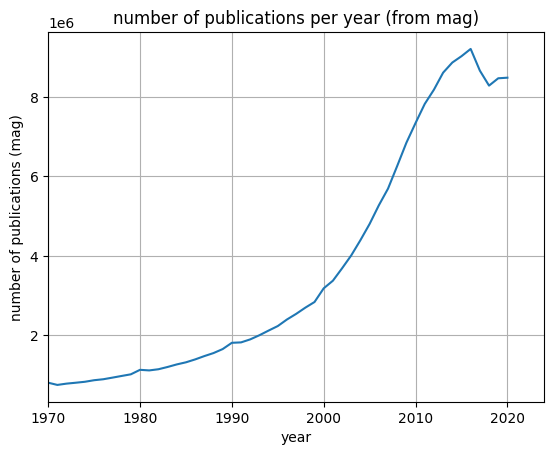

In [5]:
mag_years = pd.read_stata(main_path + 'magyear.dta')
mag_years_by_years = mag_years.groupby('year').count()

mag_years_by_years = mag_years_by_years[mag_years_by_years.index >= 1970]
mag_years_by_years = mag_years_by_years[mag_years_by_years.index <= 2020]


## plot mag dates distribution 
plt.plot(mag_years_by_years.index , mag_years_by_years['magid'])
plt.grid()
plt.xlim([1970,2024])
plt.xlabel('year')
plt.ylabel('number of publications (mag)')
plt.title('number of publications per year (from mag)')
plt.show()

In [ ]:
## openalex dates are not correct around year 2000. We use MAG dates instead. 
## save dates from MAG of the papers written by SIs. 

list_papers = []
for author_id in tqdm(dic_works):
    list_papers += [ int(elem[1:]) for elem in list(dic_works[author_id].keys()) ] 

set_papers = set(list_papers)
gk_mag_years = mag_years[mag_years['magid'].isin(set_papers)]
gk_mag_years = gk_mag_years.set_index('magid')
dic_gk_mag_years = gk_mag_years.to_dict('index')

dic_gk_mag_years = { int(k) : v for k,v in dic_gk_mag_years.items() } 

import json
json = json.dumps(dic_gk_mag_years)
f = open(main_path + "data/gatekeepers_years_mag.json","w")
f.write(json)
f.close()

## Load SIs

### Load SI file 

In [6]:
## add number of papers / patents for each SI 
path = "/home/fs01/spec1142/Emma/GateKeepers/"  + "gatekeepers_intermediate_clean_v5.tsv"
df = pd.read_csv(path , delimiter = '\t'  )

df['number of papers'] = [ len(dic_works[author]) if author in dic_works else None for author in df['author_id']  ]
df['number of patents'] = [ len(dic_patents[inventor]) if inventor in dic_patents else None for inventor in df['inventor_id'] ]

df.to_csv(path, sep = "\t" , index = False)

In [7]:
## load SI file. 
## keep only high confidence data 

threshold = 0.5 

path = "/home/fs01/spec1142/Emma/GateKeepers/"  + "gatekeepers_intermediate_clean_v5.tsv"
df = pd.read_csv(path , delimiter = '\t'  )
df = df[ (df['number of match'] / df['number of comparison'] > threshold) ]


In [8]:
## group SIs by transitivy 

data=df[["inventor_id" , "author_id"]].to_numpy()
clusters = []
G = nx.Graph()
G.add_edges_from(data)
count = 0 
for connected_component in nx.connected_components(G):
    clusters.append(connected_component)
    
print("Number of gatekeepers:" , len(clusters))

Number of gatekeepers: 581566


In [9]:
## organize SI in a dictionary 'dic_clusters'. 
## keys: count of SIs, values: OA ids and name and PV ids and name. 

dic_inventor_name = df[["inventor_id" , "inventor_name"]].drop_duplicates("inventor_id").set_index("inventor_id").to_dict("index")
dic_author_name = df[["author_id" , "author_name"]].drop_duplicates("author_id").set_index("author_id").to_dict("index")

dic_clusters = {}
count = 0 

for cluster in tqdm(clusters):
    dic_clusters[count] = {}
    dic_clusters[count]["OA"] = []
    dic_clusters[count]["PV"] = []
    for elem in cluster:
        
        if elem[0] == "A":
            dic_clusters[count]["OA"].append(  ( elem , dic_author_name[elem]) )
        else:
            dic_clusters[count]["PV"].append( ( elem ,  dic_inventor_name[elem]))
        
    count += 1
        

100%|████████████████████████████████| 581566/581566 [00:07<00:00, 80808.62it/s]


### Count SIs

In [10]:
## count inventors and patents

count = 0 
list_patents = [] 
number_inventors = 0 
for count in tqdm(dic_clusters):
    for inventor_id in dic_clusters[count]["PV"]:
        if inventor_id[0] in dic_patents:
            number_inventors += 1
            inventor_id= inventor_id[0]
            list_patents += list(dic_patents[inventor_id].keys())
        else:
            print(inventor_id)
            
print("Number of inventor ids:" , number_inventors) 
print("Number of patents:" , len(list_patents)) 
print("Number of unique patents:" , len(set(list_patents))) 


  0%|                                                | 0/581566 [00:00<?, ?it/s]


NameError: name 'dic_patents' is not defined

In [ ]:
## count authors and works


count = 0 
list_works = [] 
number_authors = 0 
for count in tqdm(dic_clusters):
    for author_id in dic_clusters[count]["OA"]:
        number_authors += 1
        author_id= author_id[0]
        list_works += list(dic_works[author_id].keys())

print("Number of author ids:" , number_authors) 
print("Number of works:" , len(list_works)) 
print("Number of unique works:" , len(set(list_works))) 


### Organize and store SI data 

In [11]:
def get_gatekeepers_data():

    """
    This function processes the data related to SIs (inventors and authors) and updates the input dictionary 'dic_clusters'.
    
    The function iterates through inventor_ids and author_ids in each cluster to gather information about patents and papers,
    respectively. It also calculates active years (year the SI published and apply for a patent) based on both application dates (for patents) and publication dates (for papers).

    For each cluster in the 'dic_clusters' dictionary, the function retrieves patent and paper data, calculates active years,
    first active year, and other relevant attributes. The updated cluster information is then stored back in the 'dic_clusters' dictionary.

    The function returns the updated 'dic_clusters' dictionary.

    Notes:
    - The function assumes that 'dic_clusters', 'dic_patents', 'dic_works', and 'dic_gk_mag_years' dictionaries are already defined and populated.
    - The function uses the 'tqdm' library for displaying a progress bar during the iteration through the cluster keys.
    """

    ## update dic_clusters for each SI
    for count in tqdm(list(dic_clusters.keys())):

        #get patents data 
        list_PV_dates = []
        cpcs = []
        for inventor_id in dic_clusters[count]["PV"]:
            
            inventor = inventor_id[0]

            if inventor in dic_patents:
            
                patents = dic_patents[inventor]
                last_patent = list(patents.keys())[0]
                gender = dic_patents[inventor][last_patent]["male_flag"]
                country_code = dic_patents[inventor][last_patent]["inventor_country_code"]  
    
                        
                list_PV_dates += [ int(dic_patents[inventor][patent]["application_date"][-4:]) for patent in patents if dic_patents[inventor][patent]["application_date"]  != None ] 
                

        ## get papers dates (OA dates and MAG dates)
        list_OA_dates = []
        list_mag_dates = []
        concepts = []
        for author_id in dic_clusters[count]["OA"]:
            author = author_id[0]
            papers = dic_works[author]

            list_OA_dates += [ int(dic_works[author][paper]["publication_date"][-4:]) for paper in papers if dic_works[author][paper]["publication_date"]  != None and len(dic_works[author][paper]["publication_date"]) == 10 ] 
            list_mag_dates += [ int(str(dic_gk_mag_years[int(paper[1:])]["year"])[:4]) for paper in papers if int(paper[1:]) in dic_gk_mag_years and  dic_gk_mag_years[int(paper[1:])]["year"]  != None ] 


        ## add gender and country (from PatentsView) to the dictionary 
        dic_clusters[count]["male_flag"] = gender
        dic_clusters[count]["country"] = country_code

        
        ## calculate first year the SI is a career SI with OA dates
        if len(list_PV_dates) > 0:
            first_GK_date = max(min(list_OA_dates) , min(list_PV_dates))
        else:
            first_GK_date = None

        ## calculate active years with OA dates
        active_GK_dates = set(list_OA_dates) & set(list_PV_dates)


        ## calculate first year the SI is a career SI with MAG dates
        if len(list_mag_dates) > 0 and len(list_PV_dates) > 0:
            first_GK_date_mag = max(min(list_mag_dates) , min(list_PV_dates))
        else:
            first_GK_date_mag = None

        ## calculate active years with MAG dates
        active_GK_dates_mag = set(list_mag_dates) & set(list_PV_dates)


        ## add first and active year from OA and MAG to the dictionary        
        dic_clusters[count]["active_years"] = list(active_GK_dates)  
        dic_clusters[count]["first_date"] = first_GK_date
        
        dic_clusters[count]["active_years_mag"] = list(active_GK_dates_mag)  
        dic_clusters[count]["first_date_mag"] = first_GK_date_mag
        

        if len(active_GK_dates)>0:
            dic_clusters[count]["first_active_year"] = min(active_GK_dates)
        else:
            dic_clusters[count]["first_active_year"] = None

        if len(active_GK_dates_mag)>0:
            dic_clusters[count]["first_active_year_mag"] = min(active_GK_dates_mag)
        else:
            dic_clusters[count]["first_active_year_mag"] = None
    
    return dic_clusters

        

In [ ]:
dic_clusters = get_gatekeepers_data()

In [ ]:
import json
json = json.dumps(dic_clusters)
f = open(main_path + "dic_clusters_mag_05.json","w")
f.write(json)
f.close()

## Load descriptive files - ( only needs to load this file to run the section plot) 

In [4]:
## load data on SIs.
## for each SI inventor_ids and author_ids, 'dic_cluster' gather information about patents and papers,(active years, first active year, and other relevant attributes

f = open(main_path + "data/dic_clusters_mag_05.json","r")
import json
dic_clusters = json.load(f)

In [18]:
## load data on SIs concepts and cpcs

f = open(main_path + "data/dic_concepts_cpcs_mag_05.json","r")
import json
dic_concepts_cpcs = json.load(f)

## Save author and inventor active years

In [15]:
## save author active years 

list_active_authors = [] 
for elem in tqdm(dic_clusters):
    if len(dic_clusters[elem]['active_years_mag'])  > 0:
        for author in dic_clusters[elem]['OA']:
            for year in dic_clusters[elem]['active_years_mag']:
                author_id = author[0]
                list_active_authors.append( ( author_id, year) )

with open(main_path + "data/active_authors_05", "wb") as fp:  
    pickle.dump(list_active_authors, fp)


100%|███████████████████████████████| 581566/581566 [00:01<00:00, 430532.74it/s]


In [19]:
## save inventor active years

list_active_inventors = [] 
for elem in tqdm(dic_clusters):
    if len(dic_clusters[elem]['active_years_mag'])  > 0:
        for inventor in dic_clusters[elem]['PV']:
            for year in dic_clusters[elem]['active_years_mag']:
                inventor_id = inventor[0]
                list_active_inventors.append( ( inventor_id, year) )

with open(main_path + "data/active_inventors_05", "wb") as fp:  
    pickle.dump(list_active_inventors, fp)

100%|███████████████████████████████| 581566/581566 [00:01<00:00, 432282.26it/s]


# Plots 

## SI pendency bias

In [63]:
patent_app = pd.read_csv(main_path + 'data/g_application.tsv' , delimiter = "\t")
patent_grant = pd.read_csv(main_path + 'data/g_patent.tsv' , usecols=['patent_id','patent_date'], delimiter = "\t")

patent_app['patent_id'] = patent_app['patent_id'].astype('str')
patent_grant['patent_id'] = patent_grant['patent_id'].astype('str')

patent = patent_grant.merge(patent_app, on='patent_id', how = 'left')

patent['patent_date'] = pd.to_datetime(patent['patent_date']).dt.date
patent['filing_date'] = pd.to_datetime(patent['filing_date'], errors ='coerce' ).dt.date

patent['diff'] = patent['patent_date'] - patent['filing_date']
patent['diff_d'] = pd.to_timedelta(patent['diff'], unit='days', errors='coerce')
patent['diff_y'] = patent['diff_d'].dt.days/365


/tmp/ipykernel_60646/1674866334.py:1: DtypeWarning: Columns (0,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  patent_app = pd.read_csv(main_path + 'data/g_application.tsv' , delimiter = "\t")
/tmp/ipykernel_60646/1674866334.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  patent_grant = pd.read_csv(main_path + 'data/g_patent.tsv' , usecols=['patent_id','patent_date'], delimiter = "\t")


<Axes: >

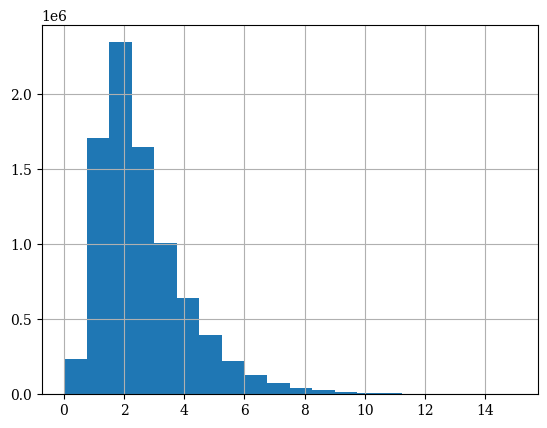

In [64]:
patent[ ( patent['diff_y'] < 15) & ( patent['diff_y'] > 0)]['diff_y'].hist(bins = 20)

In [65]:
## function which return the most frequent element of a list
def most_frequent(List):
    if List != None:
        random.shuffle(List)
        occurence_count = Counter(List)
        return occurence_count.most_common(1)[0][0]
    else:
        return None

## store the numebr of SIs over time (first time the SI has ever published and apply for a patent in its career)
number_new_gatekeepers = { year : 0 for year in range(1970,2023)}

k = 0 
for count in tqdm(dic_clusters):

    year = dic_clusters[count]["first_date_mag"]
    if year in number_new_gatekeepers: 
        number_new_gatekeepers[year] += 1


100%|███████████████████████████████| 581566/581566 [00:01<00:00, 318249.66it/s]


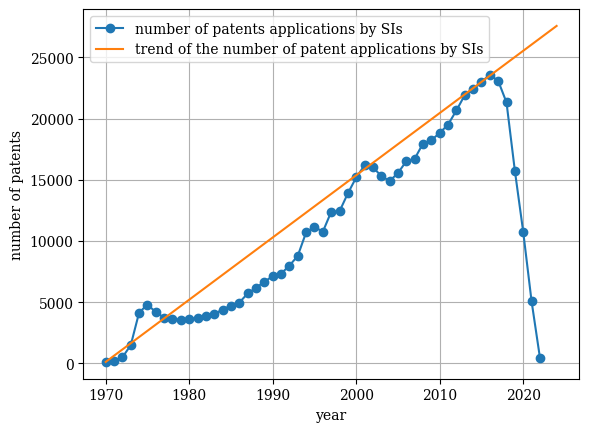

In [66]:
X = [ k for k in range(1970,2025) ] 
Y = [ number_new_gatekeepers[1970] + k*(number_new_gatekeepers[2015] - number_new_gatekeepers[1970]) /45 for k in range(55) ] 
plt.plot(number_new_gatekeepers.keys() , number_new_gatekeepers.values(), marker='o')
plt.plot(X,Y)
plt.grid()
plt.xlabel('year')
plt.ylabel('number of patents')
plt.legend(['number of patents applications by SIs','trend of the number of patent applications by SIs'])


In [68]:
list_keys = list(number_new_gatekeepers.keys())
for k in range(44,len(list_keys)):
    diff= - 100* (number_new_gatekeepers[list_keys[k]] - Y[list_keys[k]-1970]) / Y[list_keys[k]-1970]
    print("Decrease of SI patents application between " + str(list_keys[k]) + " and " + str(list_keys[k]+1) +": " +  str(round(diff,3)) + "%")

Decrease of SI patents application between 2014 and 2015: 0.412%
Decrease of SI patents application between 2015 and 2016: -0.0%
Decrease of SI patents application between 2016 and 2017: -0.33%
Decrease of SI patents application between 2017 and 2018: 3.851%
Decrease of SI patents application between 2018 and 2019: 13.053%
Decrease of SI patents application between 2019 and 2020: 37.097%
Decrease of SI patents application between 2020 and 2021: 57.901%
Decrease of SI patents application between 2021 and 2022: 80.48%
Decrease of SI patents application between 2022 and 2023: 98.185%


In [71]:
for delta in range(6,0,-1):
    number_of_application = 100 - 100*len(patent[ ( patent['diff_y'] < delta-0.5) & ( patent['diff_y'] > 0)]) / len(patent[ ( patent['diff_y'] < 15) & ( patent['diff_y'] > 0)])
    print("Proportion of US applications pending during more than " + str(delta) + " years (missign for " + str(2023 - delta) + " to " + "2023): " + str(round(number_of_application,3)) + "%")



Proportion of US applications pending during more than 6 years (missign for 2017 to 2023): 5.19%
Proportion of US applications pending during more than 5 years (missign for 2018 to 2023): 10.883%
Proportion of US applications pending during more than 4 years (missign for 2019 to 2023): 21.832%
Proportion of US applications pending during more than 3 years (missign for 2020 to 2023): 42.118%
Proportion of US applications pending during more than 2 years (missign for 2021 to 2023): 77.133%
Proportion of US applications pending during more than 1 years (missign for 2022 to 2023): 99.474%


## SI first occupation 

In [13]:
## for each SI, identify if they started with a paper or a patent 

occupation_papers = len([  dic_clusters[count]["first_occupation"] for count in dic_clusters if  'first_occupation' in dic_clusters[count]  and dic_clusters[count]["first_occupation"] == "Papers" ] )
occupation_patents = len([  dic_clusters[count]["first_occupation"] for count in dic_clusters if 'first_occupation' in dic_clusters[count]  and dic_clusters[count]["first_occupation"]  == "Patents"] )
occupation_both = len([  dic_clusters[count]["first_occupation"] for count in dic_clusters if 'first_occupation' in dic_clusters[count]  and dic_clusters[count]["first_occupation"]  == "Both"] )


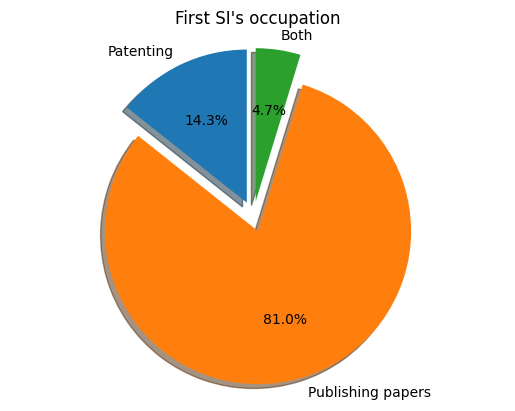

In [14]:
## plot the SI's first occupation as a pie chart

labels = 'Patenting', 'Publishing papers', 'Both'
sizes = [occupation_patents ,  occupation_papers , occupation_both]
explode = (0.1, 0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title("First SI's occupation")
plt.show()

## Sankey CONCEPTS / CPCS

### Calculate main concepts / cpcs 

In [ ]:
## calculate and store the main patent cpcs and paper concepts of each SI. 
dic_concepts_cpcs = {}

## cpc section and their corresponding labels. 
dic_cpcs = {"A" : "HUMAN NECESSITIES" , 
             "B" : "PERFORMING OPERATIONS; TRANSPORTING"  ,
             "C"  : "CHEMISTRY; METALLURGY",
             "D"  : "TEXTILES; PAPER", 
             "E"  : "FIXED CONSTRUCTIONS",
             "F": "MECHANICAL ENGINEERING; LIGHTING; HEATING; WEAPONS; BLASTING"  ,
             "G" : "PHYSICS" ,
             "H" : "ELECTRICITY",
             "Y" : "GENERAL TAGGING OF NEW TECHNOLOGICAL DEVELOPMENTS;" }


## function which return the most frequent element of a list
def most_frequent(List):
    if List != []:
        random.shuffle(List)
        occurence_count = Counter(List)
        return occurence_count.most_common(1)[0][0]
    else:
        return None
   

## we only consider the concepts and cpcs of papers and patents published (or applied for) during active years 
for count in tqdm(list(dic_clusters.keys())):

    active_years = set(dic_clusters[count]["active_years_mag"])
    
    concepts = []
    cpcs = []

    ## get all the concepts of the papers published during active years (using MAG dates) 
    for author in dic_clusters[count]["OA"]:
        author_id = author[0]
        if author_id in dic_works:
            for work_id in dic_works[author_id]:
                if dic_works[author_id][work_id]["concepts"] != None  and float(work_id[1:]) in dic_gk_mag_years and str(dic_gk_mag_years[float(work_id[1:])]["year"])[:4].isnumeric() and int(str(dic_gk_mag_years[float(work_id[1:])]["year"])[:4]) in active_years:
                    concepts +=  dic_works[author_id][work_id]["concepts"]

    ## get all the cpcs of the patents applied for during active years (using MAG dates) 
    for inventor in dic_clusters[count]["PV"]:
        inventor_id = inventor[0]
        if inventor_id in dic_patents:
            for patent_id in dic_patents[inventor_id]:
                if  dic_patents[inventor_id][patent_id]["application_date"] != None and dic_patents[inventor_id][patent_id]["cpcs_sections"] != None and int(dic_patents[inventor_id][patent_id]["application_date"][-4:]) in active_years:
                    cpcs += dic_patents[inventor_id][patent_id]["cpcs_sections"]

    ## calculate the most frequent concept and cpcs.
    if concepts != [] and cpcs != []:
        dic_concepts_cpcs[count] = {}
        dic_concepts_cpcs[count]["concepts"] = concepts
        dic_concepts_cpcs[count]["concept"] = most_frequent(concepts)
        dic_concepts_cpcs[count]["cpc"] = dic_cpcs[most_frequent(cpcs)]
        dic_concepts_cpcs[count]["cpcs"] = cpcs

                        

In [ ]:
## save file which and store the main patent cpcs and paper concepts of each SI. 

import json
json = json.dumps(dic_concepts_cpcs)
f = open(main_path + "data/dic_concepts_cpcs_mag_05.json","w")
f.write(json)
f.close()

### Plot Sankey 

In [21]:
## load file which and store the main patent cpcs and paper concepts of each SI. 

f = open(main_path + "data/dic_concepts_cpcs_mag_05.json","r")
import json
dic_concepts_cpcs = json.load(f)

In [22]:
table = pd.DataFrame(dic_concepts_cpcs).T
table

,concepts,concept,cpc,cpcs
0,"[Physics, Materials science, Physics, Psycholo...",Materials science,PHYSICS,"[C, G, G, Y, F, G, F]"
1,"[Environmental science, Engineering]",Environmental science,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,"[F, F, B]"
2,"[Computer science, Physics, Physics, Chemistry...",Chemistry,PHYSICS,[G]
3,"[Biology, Medicine, Biology, Biology, Biology]",Biology,CHEMISTRY; METALLURGY,"[C, A]"
4,"[Engineering, Materials science, Materials sci...",Materials science,FIXED CONSTRUCTIONS,"[E, E]"
...,...,...,...,...
581559,"[Medicine, Engineering, Biology]",Medicine,CHEMISTRY; METALLURGY,"[C, G]"
581561,"[Biology, Medicine, Biology, Medicine, Medicin...",Biology,HUMAN NECESSITIES,"[A, C, G, G, C, A]"
581562,"[History, Engineering, Physics, Physics, Physi...",Engineering,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,"[F, Y]"
581563,"[Materials science, Chemistry, Materials scien...",Materials science,GENERAL TAGGING OF NEW TECHNOLOGICAL DEVELOPME...,"[Y, C]"


In [25]:
## write long cpc names into multiple lines 

table['cpc'] = table['cpc'].replace('GENERAL TAGGING OF NEW TECHNOLOGICAL DEVELOPMENTS;', 'GENERAL TAGGING OF NEW \nTECHNOLOGICAL DEVELOPMENTS;')
table['cpc'] = table['cpc'].replace('PERFORMING OPERATIONS; TRANSPORTING', 'PERFORMING OPERATIONS; \nTRANSPORTING')
table['cpc'] = table['cpc'].replace("MECHANICAL ENGINEERING; LIGHTING; HEATING; WEAPONS; BLASTING", "MECHANICAL ENGINEERING; \nLIGHTING; HEATING; \nWEAPONS; BLASTING")


<Axes: >

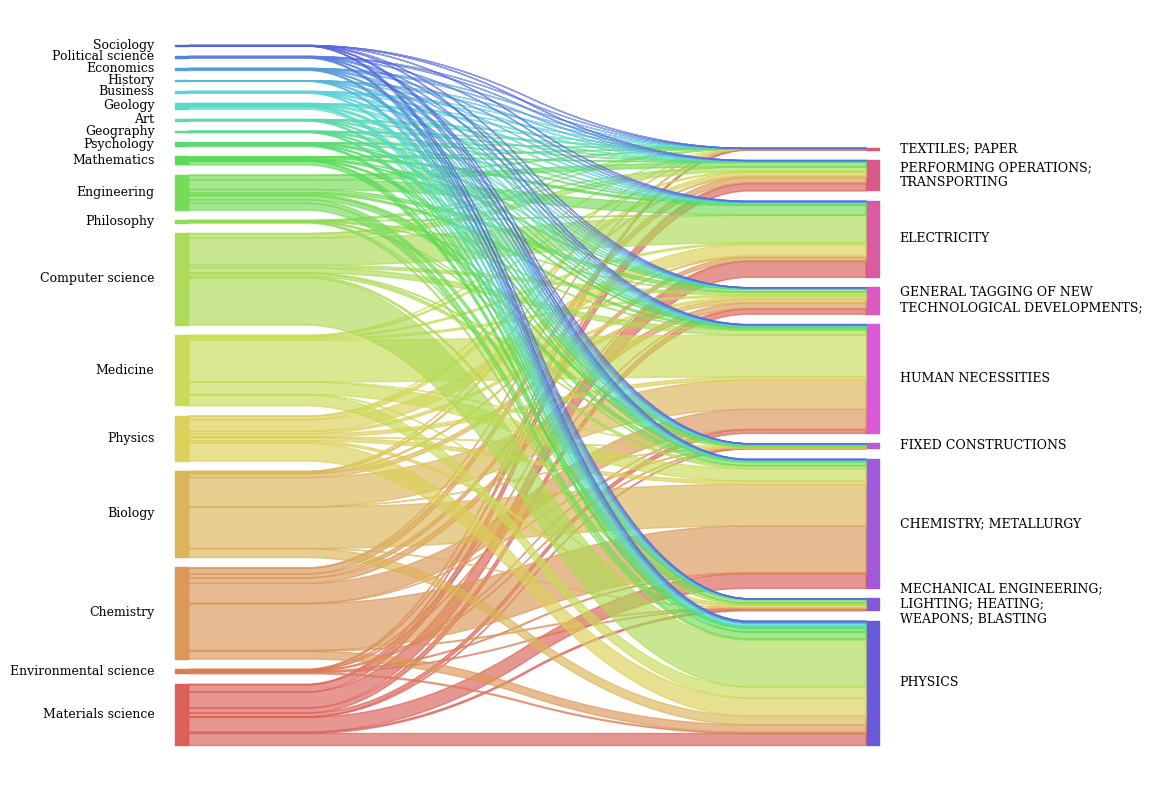

In [26]:
## plot sankey 

fig, ax = plt.subplots(figsize=(10, 10))
sankey(table["concept"] , table["cpc"],  aspect=100,  fontsize=9, ax = ax  )

## Description of the new SIs over time

### Get number of new SIs / authors / inventors each year

In [28]:
## function which return the most frequent element of a list
def most_frequent(List):
    if List != None:
        random.shuffle(List)
        occurence_count = Counter(List)
        return occurence_count.most_common(1)[0][0]
    else:
        return None

## store the numebr of SIs over time (first time the SI has ever published and apply for a patent in its career)
number_new_gatekeepers = { year : 0 for year in range(1970,2023)}


k = 0 
for count in tqdm(dic_clusters):

    year = dic_clusters[count]["first_date_mag"]
    if year in number_new_gatekeepers: 
        number_new_gatekeepers[year] += 1


100%|███████████████████████████████| 581566/581566 [00:00<00:00, 624663.14it/s]


In [31]:
def get_number_new_authors():

    """
    This function retrieves the number of new authors per year from a PostgreSQL database and returns a dictionary with the counts.

    The function establishes a connection to the database, executes a SQL query to fetch the count of new authors per year,
    and stores the results in a dictionary. The dictionary keys represent the years, and the values represent the number of new authors for that year.

    The function assumes that the 'user' and 'password' variables for the PostgreSQL database connection are already defined.
    The function returns a dictionary ('dic_new_authors') containing the number of new authors per year.

    """

    #establishing the connection
    conn = psycopg2.connect("user=" + user + " password=" + password )
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()

    text = """ SELECT COUNT(*) , date 
           FROM ( SELECT  DATE_PART('Year', MIN(w.publication_date)) AS date
           FROM works_authors_OpenAlex AS wa
           LEFT JOIN works_OpenAlex AS w ON wa.work_id = w.work_id
           GROUP BY wa.author_id
            ) AS min_year 
           GROUP BY min_year.date
           """
    

    cursor.execute(text)
    
    res = cursor.fetchall()
    #Closing the connection
    conn.close()
    
    dic_new_authors = { year : 0 for year in range(1980,2023) } 
    
    
    for elem in tqdm(res):
        if elem[1] != None:
            year_app = elem[1]
            if year_app in dic_new_authors:
                dic_new_authors[year_app] += elem[0]
                
    return dic_new_authors
    

In [32]:
#dic_new_authors = get_number_new_authors()

dic_new_authors = {1980: 515065,
 1981: 497548,
 1982: 514573,
 1983: 526390,
 1984: 544766,
 1985: 567732,
 1986: 608177,
 1987: 632932,
 1988: 673633,
 1989: 733060,
 1990: 806087,
 1991: 779717,
 1992: 810366,
 1993: 839532,
 1994: 901933,
 1995: 957429,
 1996: 1037028,
 1997: 1078376,
 1998: 1121149,
 1999: 1162917,
 2000: 1340256,
 2001: 1391803,
 2002: 1559720,
 2003: 1626120,
 2004: 1791689,
 2005: 1898646,
 2006: 2030866,
 2007: 2111971,
 2008: 2264729,
 2009: 2470161,
 2010: 2647973,
 2011: 2788664,
 2012: 2989328,
 2013: 3160591,
 2014: 3326653,
 2015: 3434163,
 2016: 3590532,
 2017: 3439671,
 2018: 3342309,
 2019: 3492574,
 2020: 3563413,
 2021: 3391859,
 2022: 4106049} 


In [33]:
def get_number_new_inventors():

    """
    This function retrieves the number of new inventors per year from a PostgreSQL database and returns a dictionary with the counts.

    The function establishes a connection to the database, executes a SQL query to fetch the count of new inventors per year,
    and stores the results in a dictionary. The dictionary keys represent the years, and the values represent the number of new inventors for that year (application year).

    The function assumes that the 'user' and 'password' variables for the PostgreSQL database connection are already defined.
    The function returns a dictionary ('dic_new_inventors') containing the number of new inventors per year.

    """

    #establishing the connection
    conn = psycopg2.connect("user=" + user + " password=" + password )
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()

    text = """ SELECT COUNT(*) , date
               FROM ( SELECT  DATE_PART('Year', MIN(a.appno_date)) AS date
               FROM inventors_PatentsView AS i 
               LEFT JOIN documentid_USPTO AS a ON a.grant_doc_num = i.patent_id
               WHERE a.grant_country = 'US' 
               GROUP BY i.inventor_id
                ) AS min_year 
               GROUP BY min_year.date
    """

    cursor.execute(text)
    
    res = cursor.fetchall()
    #Closing the connection
    conn.close()
    
    dic_new_inventors = { year : 0 for year in range(1980,2023) } 
    
    
    for elem in tqdm(res):
        if elem[1] != None:
            year_app = elem[1]
            if year_app in dic_new_inventors:
                dic_new_inventors[year_app] += elem[0]
                
    return dic_new_inventors

In [34]:
#dic_new_inventors = get_number_new_inventors()

dic_new_inventors = {1980: 42357,
 1981: 50977,
 1982: 46710,
 1983: 42189,
 1984: 42947,
 1985: 44913,
 1986: 45796,
 1987: 48946,
 1988: 52198,
 1989: 53866,
 1990: 54798,
 1991: 55433,
 1992: 56474,
 1993: 59794,
 1994: 67242,
 1995: 70673,
 1996: 75494,
 1997: 83115,
 1998: 85704,
 1999: 90042,
 2000: 95199,
 2001: 97447,
 2002: 95992,
 2003: 92334,
 2004: 89482,
 2005: 86965,
 2006: 87054,
 2007: 91026,
 2008: 94400,
 2009: 90264,
 2010: 96430,
 2011: 99137,
 2012: 104924,
 2013: 113151,
 2014: 118804,
 2015: 119039,
 2016: 120784,
 2017: 123649,
 2018: 121989,
 2019: 114818,
 2020: 79890,
 2021: 25210,
 2022: 2461}

### Plot the evolution over time

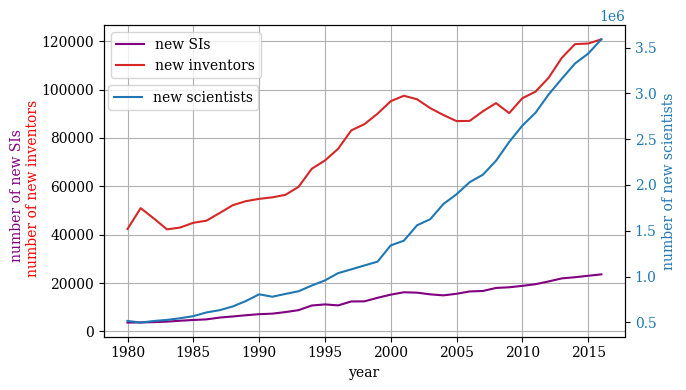

In [39]:
## plot the evolution of the number of new SIs / new authors / new inventors over time

X_GK = list(dic_new_inventors.keys())
Y_GK = np.array(list({ k : v for k, v in number_new_gatekeepers.items() if 2022 >= k >= 1980}.values()))
Y_PV = np.array(list(dic_new_inventors.values()))
Y_OA = np.array(list(dic_new_authors.values()))

fig, ax1 = plt.subplots(figsize = (7,4))

color = 'tab:red'
ax1.set_xlabel('year')
line_si, = ax1.plot(X_GK[:-6], Y_GK[:-6], color='purple')
line_PV, = ax1.plot(X_GK[:-6], Y_PV[:-6], color=color)
line_si.set_label('new SIs')
line_PV.set_label('new inventors')

ax1.legend()
ax1.tick_params(axis='y')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('number of new scientists', color=color)  # we already handled the x-label with ax1
line_OA, = ax2.plot(X_GK[:-6], Y_OA[:-6], color=color)
line_OA.set_label('new scientists')
ax2.legend( bbox_to_anchor=(-.19, 0.33, 0.5, 0.5))
ax2.tick_params(axis='y', labelcolor=color)
ax1.grid()
#ax2.set_title('Number of new SIs, inventors and scientists over time')
plt.text(-0.18, 0.25, 'number of new SIs', color='purple', transform=ax2.transAxes, rotation='vertical')
plt.text(-0.15, 0.20, 'number of new inventors', color='red', transform=ax2.transAxes, rotation='vertical')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

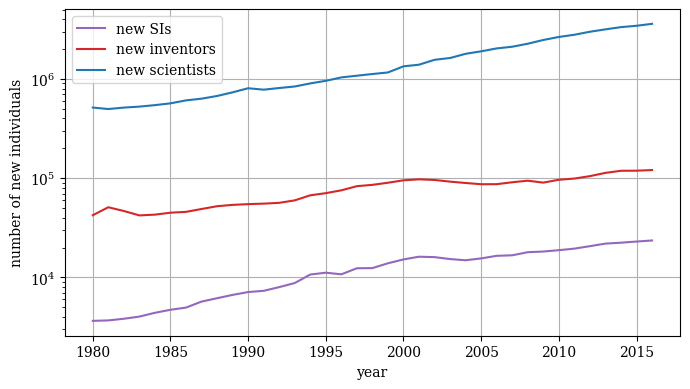

In [40]:
## plot the evolution of the number of new SIs / new authors / new inventors over time

X_GK = list(dic_new_inventors.keys())
Y_GK = np.array(list({ k : v for k, v in number_new_gatekeepers.items() if 2022 >= k >= 1980}.values()))
Y_PV = np.array(list(dic_new_inventors.values()))
Y_OA = np.array(list(dic_new_authors.values()))


fig, ax1 = plt.subplots(figsize = (7,4))

color1 = 'tab:purple'
color2 = 'tab:red'
color3 = 'tab:blue'

ax1.set_xlabel('year')
ax1.plot(X_GK[:-6], Y_GK[:-6], color=color1)
ax1.plot(X_GK[:-6], Y_PV[:-6], color=color2)
ax1.plot(X_GK[:-6], Y_OA[:-6], color=color3)
ax1.set_yscale('log')
ax1.grid()
#ax1.set_title('Number of new SIs, inventors and scientists over time - log scale')
ax1.set_ylabel('number of new individuals') 
ax1.legend(['new SIs','new inventors', 'new scientists'])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Description of the SIs over time by gender

### Get SI and inventors proportions by gender 

In [42]:
## store the number of new SI and their gender
dic_gender = {}

## cpc section and their corresponding labels. 
dic_cpcs = {"A" : "HUMAN NECESSITIES" , 
             "B" : "PERFORMING OPERATIONS; TRANSPORTING"  ,
             "C"  : "CHEMISTRY; METALLURGY",
             "D"  : "TEXTILES; PAPER", 
             "E"  : "FIXED CONSTRUCTIONS",
             "F": "MECHANICAL ENGINEERING; LIGHTING; HEATING; WEAPONS; BLASTING"  ,
             "G" : "PHYSICS" ,
             "H" : "ELECTRICITY",
             "Y" : "GENERAL TAGGING OF NEW TECHNOLOGICAL DEVELOPMENTS;" }


## function which return the most frequent element of a list
def most_frequent(List):
    if List != []:
        random.shuffle(List)
        occurence_count = Counter(List)
        return occurence_count.most_common(1)[0][0]
    else:
        return None


## for each SI, store in 'dic_gender' their gender, first year they have been publishing and patenting (from MAG), cpc, concept and country (from PatentsView) 
for count in tqdm(list(dic_clusters.keys())):

    year = dic_clusters[count]['first_date_mag']

    if str(count) in dic_concepts_cpcs:
        concepts = dic_concepts_cpcs[str(count)]['concept']
        cpcs = dic_concepts_cpcs[str(count)]['cpc']
    else:
        concepts = None
        cpcs = None
    
    dic_gender[count] = {}
    dic_gender[count]["gender"] = dic_clusters[count]["male_flag"]
    dic_gender[count]["arrival_year"] = year
    dic_gender[count]["country_code"] = dic_clusters[count]["country"]
    dic_gender[count]["concept"] = concepts
    dic_gender[count]["cpc"] =  cpcs
   


100%|███████████████████████████████| 581566/581566 [00:03<00:00, 185929.32it/s]


In [56]:
gk = pd.DataFrame(dic_gender).T
gk = gk[gk["arrival_year"].notnull()]
gk.head()

,gender,arrival_year,country_code,concept,cpc
0,M,2012,BY,Materials science,PHYSICS
1,M,2004,US,Environmental science,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,M,2006,CH,Chemistry,PHYSICS
3,U,1990,US,Biology,CHEMISTRY; METALLURGY
4,M,1992,US,Materials science,FIXED CONSTRUCTIONS


In [48]:
def get_PV_proportion_by_gender():

    """
    This function retrieves the number of patent applications by gender (Female, Male, Unknown) every year from a PostgreSQL database and returns a dictionary with the counts.
    The dictionary keys represent the genders (F, M, U), and the values are inner dictionaries with keys representing the years and values representing the number of patent applications for that year and gender.

    The function assumes that the 'user' and 'password' variables for the PostgreSQL database connection are already defined.
    It also assumes that the required tables ('inventors_PatentsView' and 'documentid_USPTO') exist in the connected database.

    The function returns a dictionary ('gender_PV') containing the number of patent applications by gender every five years.
    """
    
    #establishing the connection
    conn = psycopg2.connect("user=" + user + " password=" + password)
    
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    
    
    text = """ SELECT COUNT(*) , date 
               FROM ( SELECT  DATE_PART('Year', MIN(a.appno_date)) AS date
               FROM inventors_PatentsView AS i 
               LEFT JOIN documentid_USPTO AS a ON a.grant_doc_num = i.patent_id
               WHERE i.gender_code = 'F' 
               GROUP BY i.inventor_id
                ) AS min_year 
               GROUP BY min_year.date
               """
    
    cursor.execute(text)
    resF = cursor.fetchall()
    
    text = """ SELECT COUNT(*) , date 
               FROM ( SELECT  DATE_PART('Year', MIN(a.appno_date)) AS date
               FROM inventors_PatentsView AS i 
               LEFT JOIN documentid_USPTO AS a ON a.grant_doc_num = i.patent_id
               WHERE i.gender_code = 'M' 
               GROUP BY i.inventor_id
                ) AS min_year 
               GROUP BY min_year.date
               """
    
    cursor.execute(text)
    resM = cursor.fetchall()
    
    text = """ SELECT COUNT(*) , date 
               FROM ( SELECT  DATE_PART('Year', MIN(a.appno_date)) AS date
               FROM inventors_PatentsView AS i 
               LEFT JOIN documentid_USPTO AS a ON a.grant_doc_num = i.patent_id
               WHERE i.gender_code = 'U' 
               GROUP BY i.inventor_id
                ) AS min_year 
               GROUP BY min_year.date
               """
    
    cursor.execute(text)
    resU = cursor.fetchall()
    
    
    cursor.close()

    gender_PV = { gender : { year : 0 for year in range(1970,2023) } for year in ['M','F','U'] } 
    
    for elem in tqdm(resF):
        if elem[1] != None:
            year_app = elem[1]
            if year_app in gender_PV['F']:
                gender_PV['F'][year_app] += elem[0]
    
    for elem in tqdm(resM):
        if elem[1] != None:
            year_app = elem[1]
            if year_app in gender_PV['M']:
                gender_PV["M"][year_app] += elem[0]
    
    for elem in tqdm(resU):
        if elem[1] != None:
            year_app = elem[1]
            if year_app in gender_PV['U']:
                gender_PV['U'][year_app] += elem[0]
     
    return  gender_PV  


#gender_PV = get_PV_proportion_by_gender()

gender_PV = {'M': {1980: 39682,
  1981: 47412,
  1982: 43249,
  1983: 38811,
  1984: 39145,
  1985: 40646,
  1986: 41147,
  1987: 43609,
  1988: 46286,
  1989: 47400,
  1990: 47961,
  1991: 48165,
  1992: 48981,
  1993: 51268,
  1994: 57116,
  1995: 59584,
  1996: 63357,
  1997: 69030,
  1998: 69164,
  1999: 68240,
  2000: 66054,
  2001: 73951,
  2002: 75421,
  2003: 73494,
  2004: 70590,
  2005: 68004,
  2006: 67117,
  2007: 69873,
  2008: 71566,
  2009: 68091,
  2010: 72112,
  2011: 73191,
  2012: 76918,
  2013: 82148,
  2014: 85089,
  2015: 84261,
  2016: 84783,
  2017: 86213,
  2018: 83844,
  2019: 76574,
  2020: 51826,
  2021: 15982,
  2022: 1466},
 'F': {1980: 1462,
  1981: 1848,
  1982: 1911,
  1983: 1925,
  1984: 2206,
  1985: 2492,
  1986: 2766,
  1987: 3175,
  1988: 3594,
  1989: 3956,
  1990: 4306,
  1991: 4633,
  1992: 4870,
  1993: 5803,
  1994: 6914,
  1995: 7564,
  1996: 8086,
  1997: 9090,
  1998: 9521,
  1999: 9796,
  2000: 9868,
  2001: 11542,
  2002: 11873,
  2003: 12001,
  2004: 11934,
  2005: 11687,
  2006: 12121,
  2007: 12978,
  2008: 13933,
  2009: 13409,
  2010: 14668,
  2011: 15070,
  2012: 15998,
  2013: 17374,
  2014: 18599,
  2015: 18880,
  2016: 19691,
  2017: 20392,
  2018: 20506,
  2019: 19580,
  2020: 12981,
  2021: 4038,
  2022: 395},
 'U': {1980: 1210,
  1981: 1715,
  1982: 1549,
  1983: 1452,
  1984: 1596,
  1985: 1775,
  1986: 1882,
  1987: 2162,
  1988: 2316,
  1989: 2510,
  1990: 2528,
  1991: 2624,
  1992: 2601,
  1993: 2702,
  1994: 3157,
  1995: 3381,
  1996: 3780,
  1997: 4432,
  1998: 4915,
  1999: 4898,
  2000: 5149,
  2001: 6118,
  2002: 6721,
  2003: 6795,
  2004: 6958,
  2005: 7274,
  2006: 7816,
  2007: 8175,
  2008: 8901,
  2009: 8764,
  2010: 9650,
  2011: 10876,
  2012: 12008,
  2013: 13628,
  2014: 15115,
  2015: 15897,
  2016: 16308,
  2017: 17036,
  2018: 17605,
  2019: 18629,
  2020: 15034,
  2021: 5163,
  2022: 592},
 'total': {1980: 42354,
  1981: 50975,
  1982: 46709,
  1983: 42188,
  1984: 42947,
  1985: 44913,
  1986: 45795,
  1987: 48946,
  1988: 52196,
  1989: 53866,
  1990: 54795,
  1991: 55422,
  1992: 56452,
  1993: 59773,
  1994: 67187,
  1995: 70529,
  1996: 75223,
  1997: 82552,
  1998: 83600,
  1999: 82934,
  2000: 81071,
  2001: 91611,
  2002: 94015,
  2003: 92290,
  2004: 89482,
  2005: 86965,
  2006: 87054,
  2007: 91026,
  2008: 94400,
  2009: 90264,
  2010: 96430,
  2011: 99137,
  2012: 104924,
  2013: 113150,
  2014: 118803,
  2015: 119038,
  2016: 120782,
  2017: 123641,
  2018: 121955,
  2019: 114783,
  2020: 79841,
  2021: 25183,
  2022: 2453}}

### Plots by gender

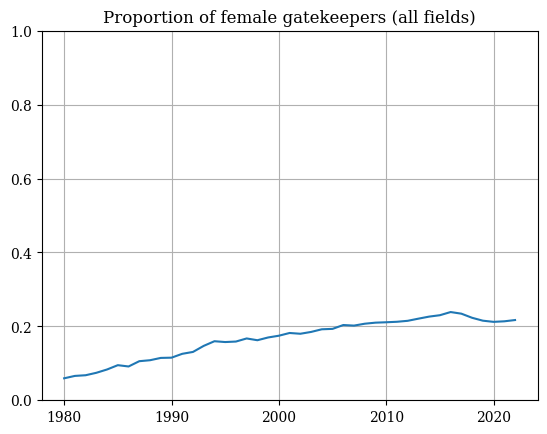

In [49]:
## plot the proportion of female SIs over time

gk = gk[gk["arrival_year"] > 1979]
gk = gk[gk["arrival_year"] < 2023]

male = gk[gk["gender"] == 'M' ]
male = pd.DataFrame(male.value_counts(["arrival_year"])).sort_values("arrival_year")


female = gk[gk["gender"] == 'F' ]
female = pd.DataFrame(female.value_counts(["arrival_year"])).sort_values("arrival_year")


plt.plot(male.index.tolist(), female['count']/(male['count'] + female['count']))
plt.ylim([0, 1])
plt.title("Proportion of female gatekeepers (all fields)", fontsize=12)
plt.grid()

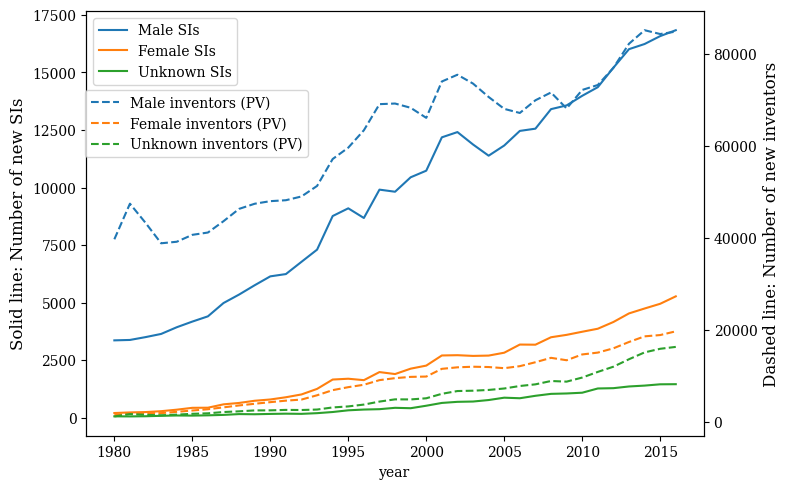

In [51]:
## comparison between the SIs new SIs and PatentsView new inventors by gender

fig, ax1 = plt.subplots(figsize = (8,5))

ax1.set_xlabel('year')
ax1.set_ylabel('Solid line: Number of new SIs', fontsize = 12 )

gk = gk[gk["arrival_year"] >= 1980]
gk = gk[gk["arrival_year"] <= 2016]

gender_PV = { key : { k : v for k,v in gender_PV[key].items() if 1980<=k<=2016 } for key in gender_PV }

male = gk[gk["gender"] == 'M' ]
male = pd.DataFrame(male.value_counts(["arrival_year"])).sort_values("arrival_year")

female = gk[gk["gender"] == 'F' ]
female = pd.DataFrame(female.value_counts(["arrival_year"])).sort_values("arrival_year")

unknown = gk[gk["gender"] == 'U' ]
unknown = pd.DataFrame(unknown.value_counts(["arrival_year"])).sort_values("arrival_year")


line1, = ax1.plot([ elem[0] for elem in male.index.tolist()],   male['count'], label = "Male SIs")
line2, = ax1.plot([ elem[0] for elem in male.index.tolist()],   female['count'], label = "Female SIs"  )
line3, = ax1.plot([ elem[0] for elem in male.index.tolist()],  unknown['count'],label = "Unknown SIs"   )

ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Dashed line: Number of new inventors',  fontsize = 12)  # we already handled the x-label with ax1
ax2.plot([ elem[0] for elem in male.index.tolist()], gender_PV["M"].values() ,linestyle='dashed', label = "Male inventors (PV)")
ax2.plot([ elem[0] for elem in male.index.tolist()], gender_PV["F"].values() , linestyle='dashed' , label = "Female inventors (PV)"  )
ax2.plot([ elem[0] for elem in male.index.tolist()],  gender_PV["U"].values() , linestyle='dashed' , label = "Unknown inventors (PV)" )
ax2.tick_params(axis='y')


ax1.legend( loc= "upper left")
ax2.legend(bbox_to_anchor = [0.37, 0.83])


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()




### Plots by concepts and gender

<Figure size 640x480 with 0 Axes>

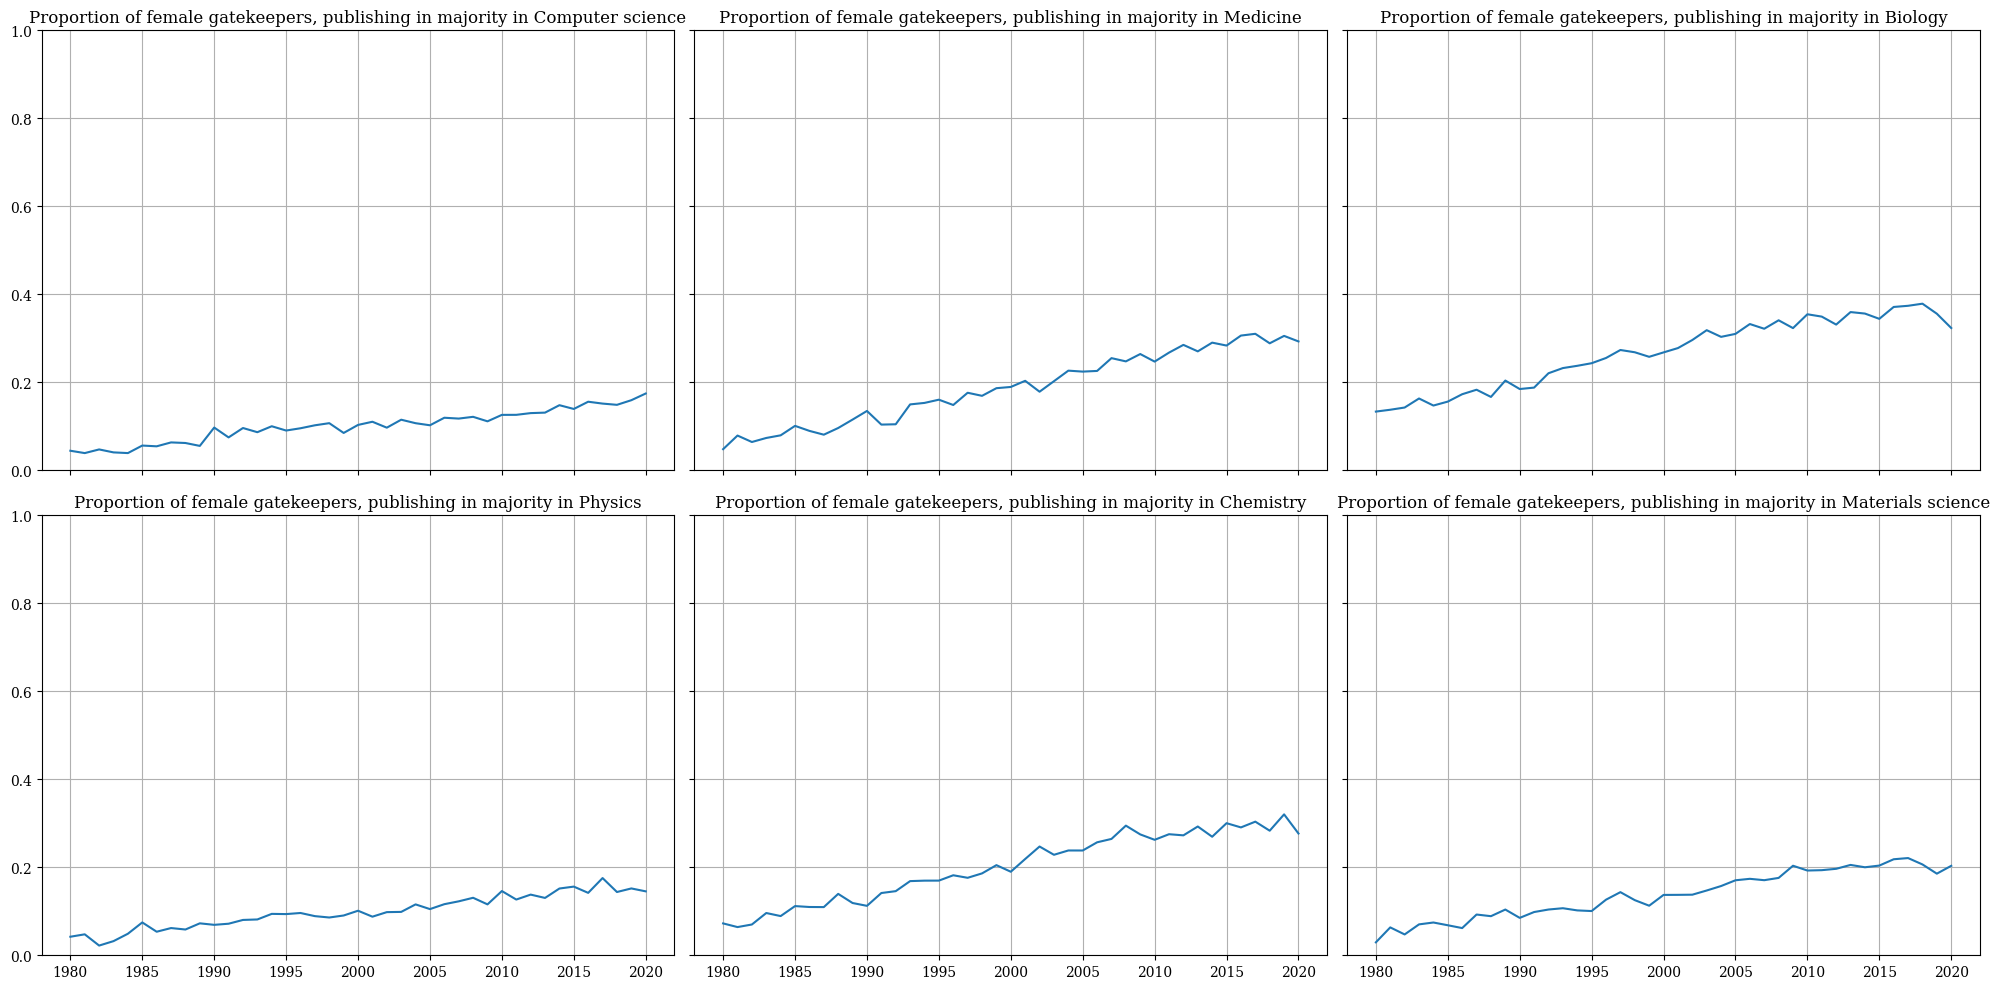

In [57]:
plt.figure()
fig , axes = plt.subplots(nrows = 2 , ncols=3 , sharex=True, sharey=True, figsize = (20,10))

i = 0 


list_concepts = ['Computer science',
 'Medicine',
 'Biology',
 'Physics',
 'Chemistry',
 'Materials science']

for concept in list_concepts:
    
    gk = gk[gk["arrival_year"] >= 1980]
    gk = gk[gk["arrival_year"] <= 20]
    
    
    male = gk[gk["gender"] == 'M' ]
    male = pd.DataFrame(male[male["concept"] == concept].value_counts(["arrival_year"])).sort_values("arrival_year")
    
    
    female = gk[gk["gender"] == 'F' ]
    female = pd.DataFrame(female[female["concept"] == concept].value_counts(["arrival_year"])).sort_values("arrival_year")
    

    ax = axes[i//3,i%3]
    ax.plot(male.index.tolist(), female['count']/(male['count'] + female['count']))
    ax.set_ylim([0, 1])
    ax.set_title("Proportion of female gatekeepers, publishing in majority in " + str(concept) , fontsize=12)
    ax.grid()
    
    i += 1
    
 

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

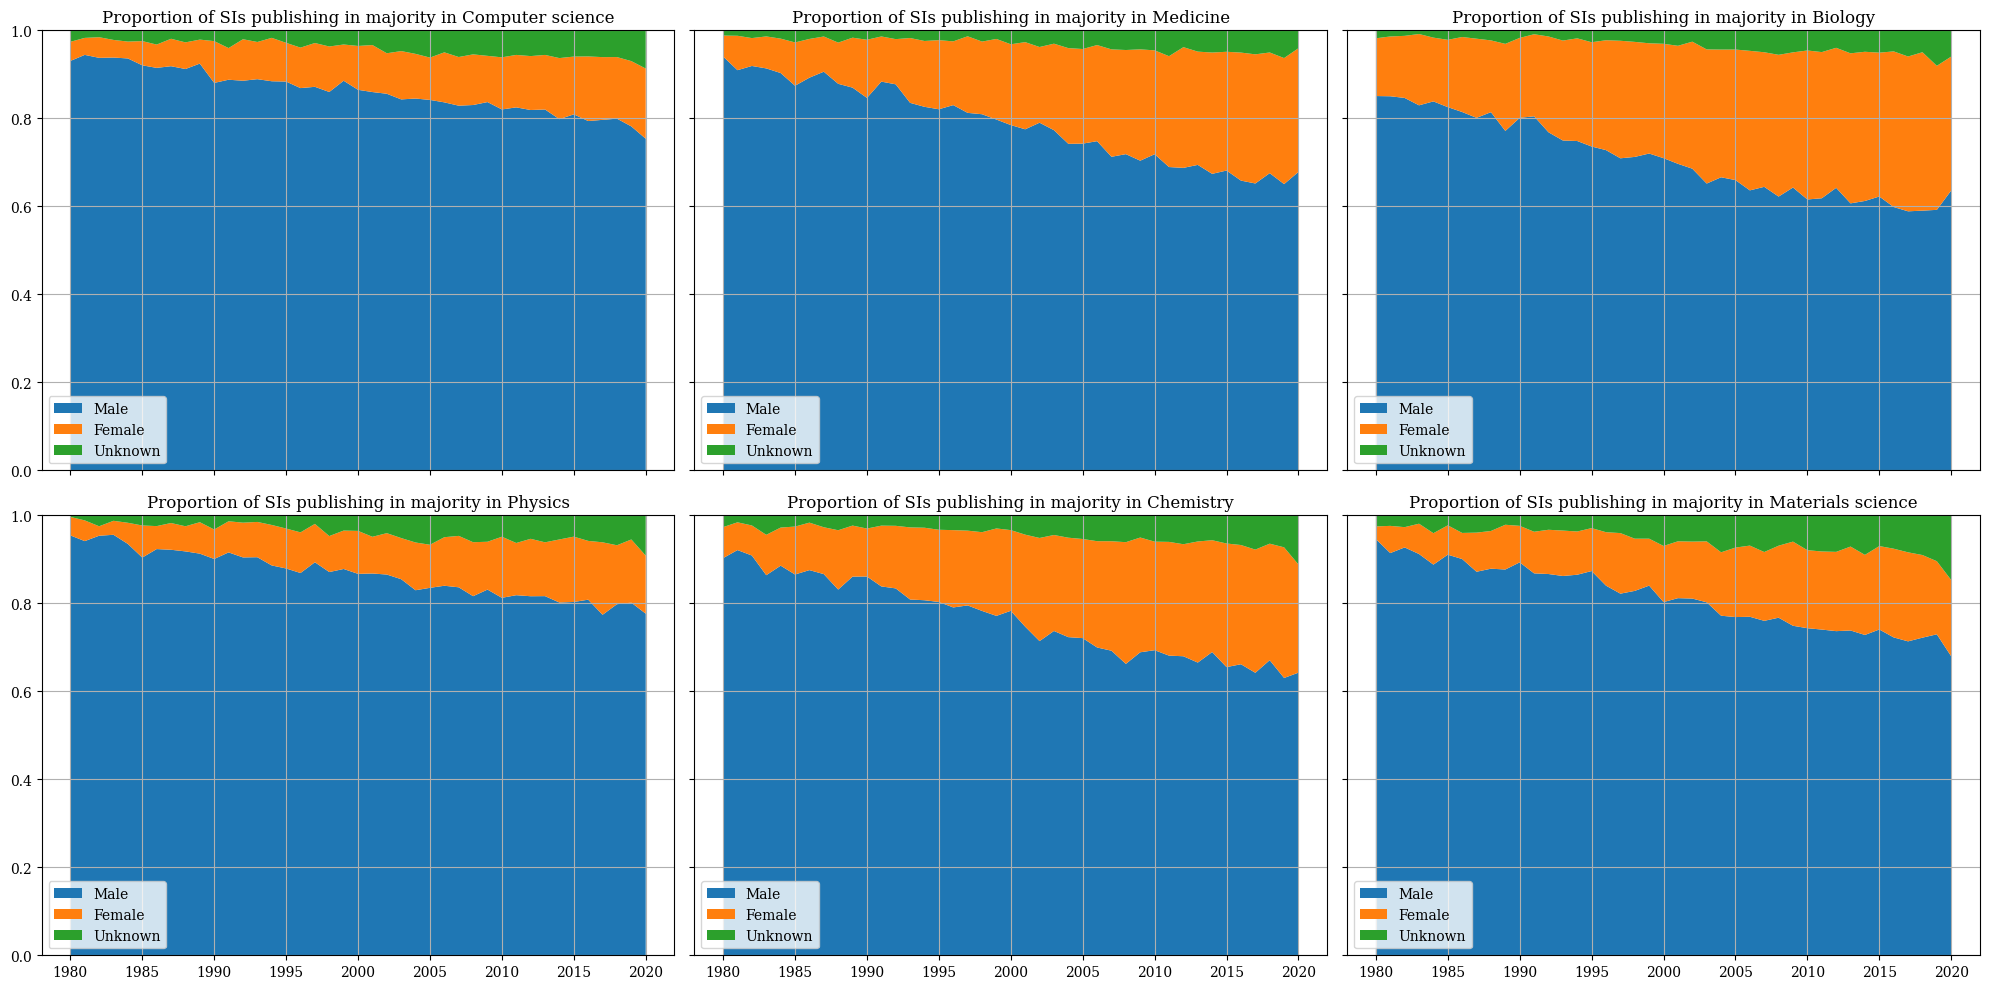

In [58]:
plt.figure()
fig , axes = plt.subplots(nrows = 2 , ncols=3 , sharex=True, sharey=True, figsize = (20,10))
#fig.delaxes(axes[1][2])
# Iterate through continents
i = 0 


list_concepts = ['Computer science',
 'Medicine',
 'Biology',
 'Physics',
 'Chemistry',
  'Materials science']

for concept in list_concepts:
    
    gk = gk[gk["arrival_year"] >= 1980]
    gk = gk[gk["arrival_year"] <= 2020]
    
    
    male = gk[gk["gender"] == 'M' ]
    male = pd.DataFrame(male[male["concept"] == concept].value_counts(["arrival_year"])).sort_values("arrival_year")
    
    
    female = gk[gk["gender"] == 'F' ]
    female = pd.DataFrame(female[female["concept"] == concept].value_counts(["arrival_year"])).sort_values("arrival_year")
    
    unknown = gk[gk["gender"] == 'U' ]
    unknown = pd.DataFrame(unknown[unknown["concept"] == concept].value_counts(["arrival_year"])).sort_values("arrival_year")
    
    ax = axes[i//3,i%3]
    ax.fill_between([ elem[0] for elem in male.index.tolist()],  np.zeros((len(female['count']))) , male['count']/(male['count'] + female['count'] + unknown['count'] ))
    ax.fill_between([ elem[0] for elem in male.index.tolist()],  male['count']/(male['count'] + female['count'] + unknown['count'] ) , ( female['count'] + male['count'] )/(male['count'] + female['count'] + unknown['count'] ))
    ax.fill_between([ elem[0] for elem in male.index.tolist()],  ( female['count'] + male['count'] ) /(male['count'] + female['count'] + unknown['count'] ) , 1 + np.zeros((len(male['count']))) )

    ax.legend(["Male" , "Female" , "Unknown"], loc = "lower left")    
    ax.set_ylim([0, 1])
    ax.set_title("Proportion of SIs publishing in majority in " + str(concept) , fontsize=12)
    ax.grid()
    #ax.set_xlim([1980,2022])
    
    i += 1
    


plt.tight_layout()
plt.show()

### Plot by country and gender

<Figure size 640x480 with 0 Axes>

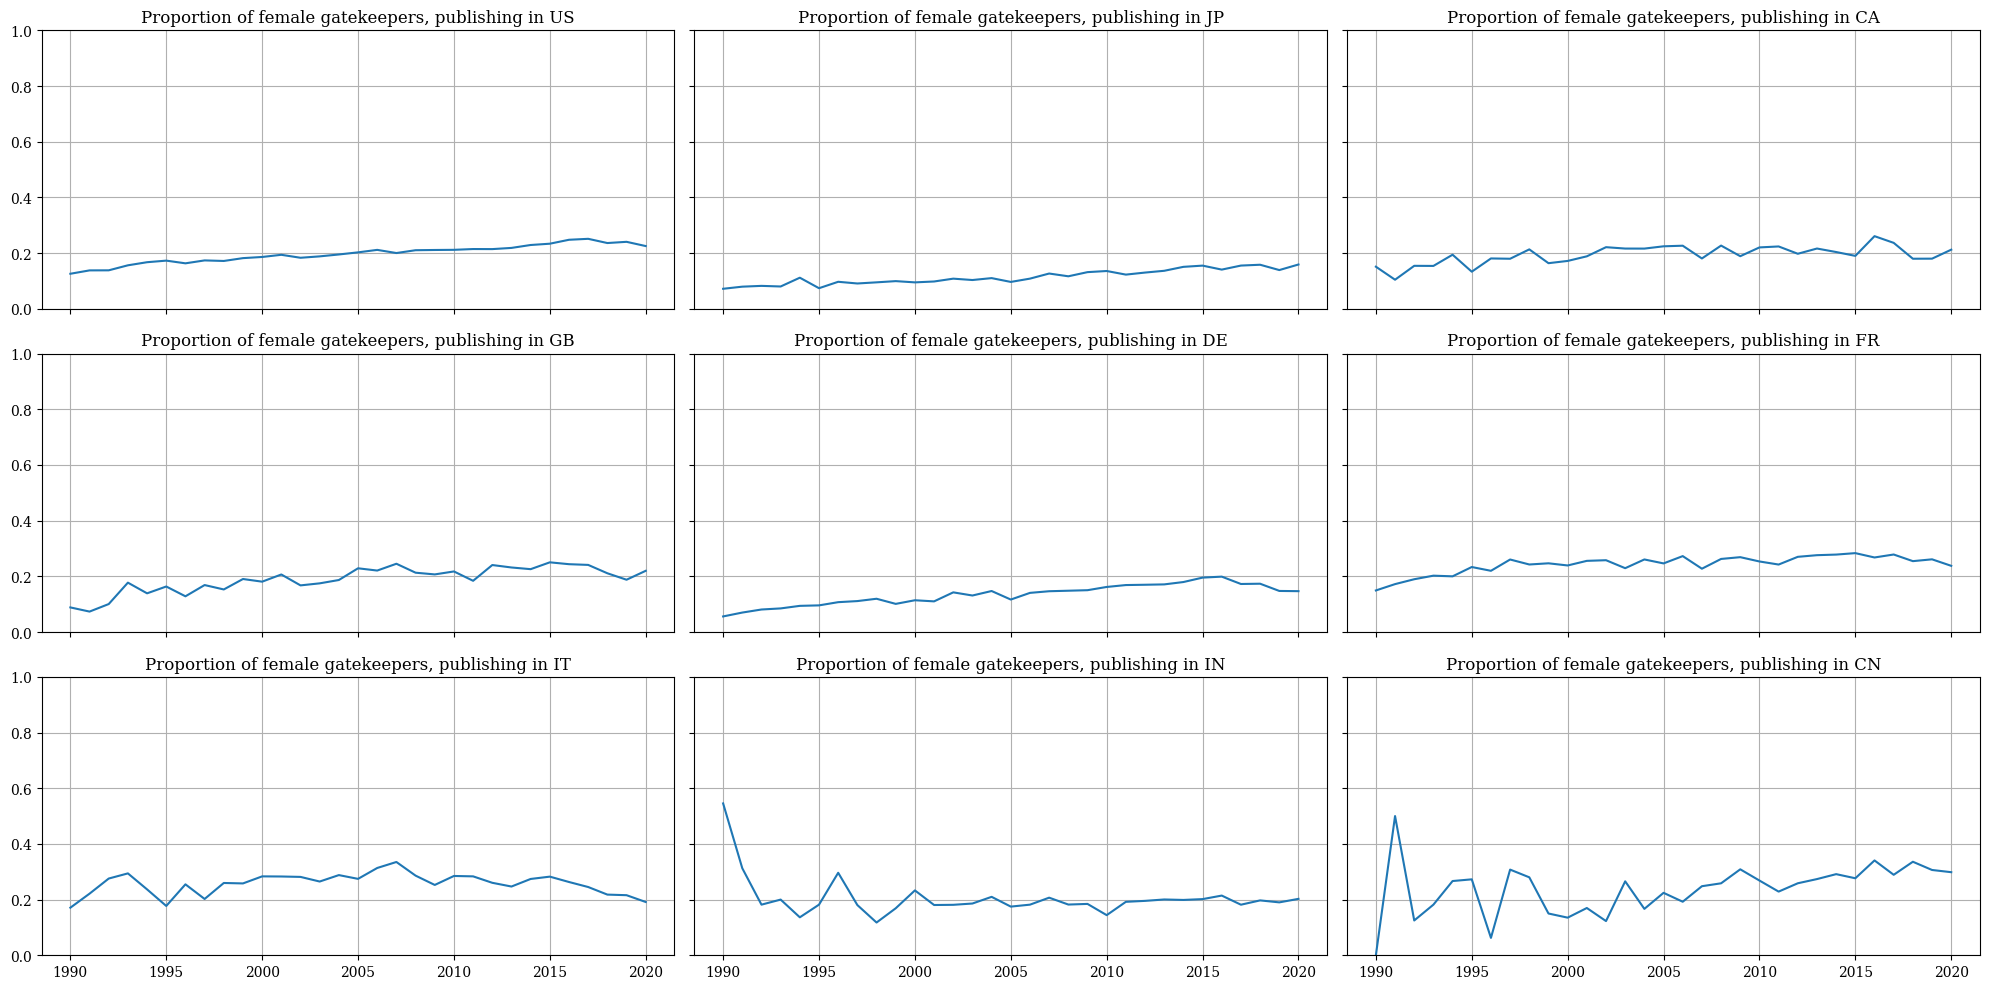

In [60]:
plt.figure()
fig , axes = plt.subplots(nrows = 3 , ncols=3 , sharex=True, sharey=True, figsize = (20,10))

i = 0 


list_countries = ['US' , 'JP' , 'CA',
                  'GB' , 'DE' , 'FR',
                  'IT' , 'IN' , 'CN']

for country_code in list_countries:
    
    gk = gk[gk["arrival_year"] >= 1990]
    gk = gk[gk["arrival_year"] <= 2020]
    
    
    male = gk[gk["gender"] == 'M' ]
    male = pd.DataFrame(male[male["country_code"] == country_code].value_counts(["arrival_year"])).sort_values("arrival_year")
    
    
    female = gk[gk["gender"] == 'F' ]
    female = pd.DataFrame(female[female["country_code"] == country_code].value_counts(["arrival_year"])).sort_values("arrival_year")
    for year in range(1990,2016):
        if year not in [ elem[0] for elem in female.index]:
            female.loc[(year,)] = 0
    
    
    
    ax = axes[i//3,i%3]
    ax.plot(male.index.tolist(), female['count']/(male['count'] + female['count']))
    ax.set_ylim([0, 1])
    ax.set_title("Proportion of female gatekeepers, publishing in " + str(country_code) , fontsize=12)
    ax.grid()
    
    i += 1
    


plt.tight_layout()
plt.show()

100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.41it/s]


<Figure size 640x480 with 0 Axes>

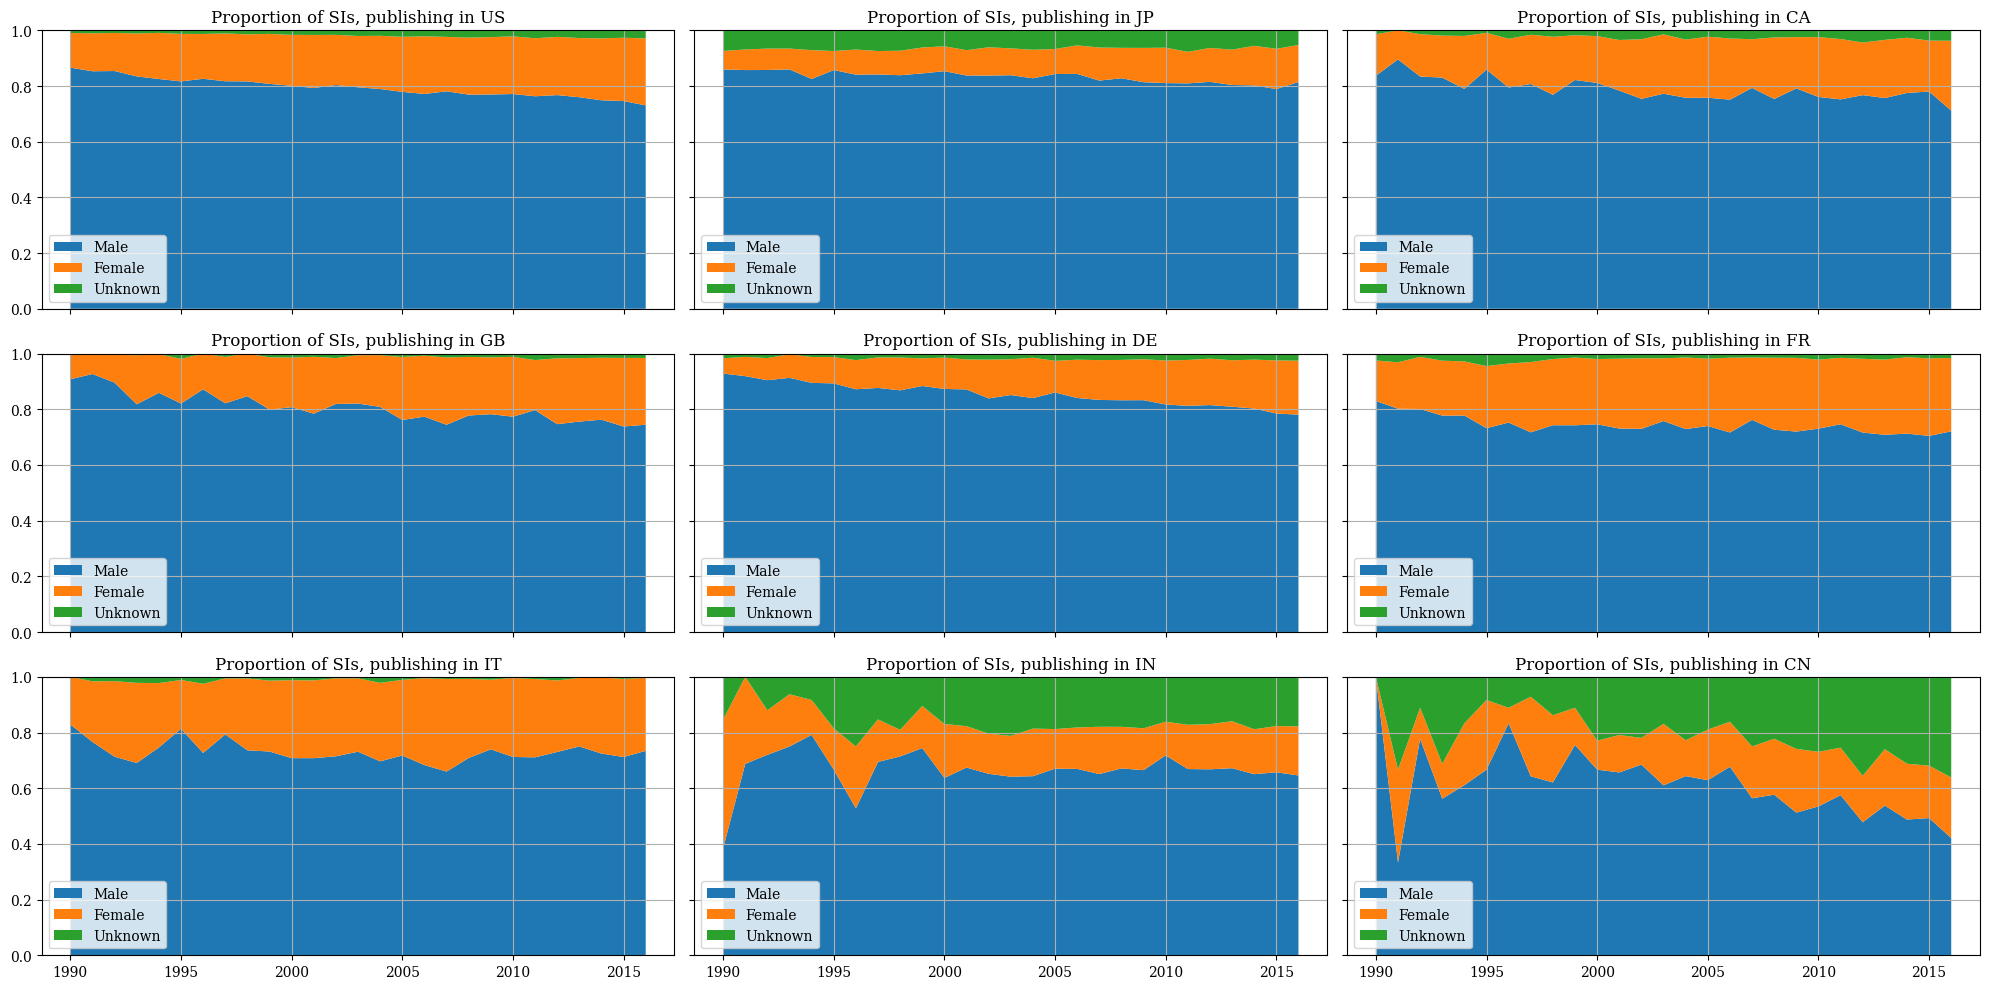

In [61]:
plt.figure()
fig , axes = plt.subplots(nrows = 3 , ncols=3 , sharex=True, sharey=True, figsize = (20,10))
#fig.delaxes(axes[1][2])
# Iterate through continents
i = 0 


list_countries = ['US' , 'JP' , 'CA',
                  'GB' , 'DE' , 'FR',
                  'IT' , 'IN' , 'CN']

for country_code in tqdm(list_countries):
    
    gk = gk[gk["arrival_year"] >= 1990]
    gk = gk[gk["arrival_year"] <= 2016]
    
    
    male = gk[gk["gender"] == 'M' ]
    male = pd.DataFrame(male[male["country_code"] == country_code].value_counts(["arrival_year"])).sort_values("arrival_year")

        
    
    female = gk[gk["gender"] == 'F' ]
    female = pd.DataFrame(female[female["country_code"] == country_code].value_counts(["arrival_year"])).sort_values("arrival_year")
    for year in range(1990,2016):
        if year not in [ elem[0] for elem in female.index]:
            female.loc[(year,)] = 0
    
    
    unknown = gk[gk["gender"] == 'U' ]
    unknown = pd.DataFrame(unknown[unknown["country_code"] == country_code].value_counts(["arrival_year"])).sort_values("arrival_year")
    for year in range(1990,2016):
        if year not in [ elem[0] for elem in unknown.index]:
            unknown.loc[(year,)] = 0
    

    
    ax = axes[i//3,i%3]
    ax.fill_between([ elem[0] for elem in male.index.tolist()],  np.zeros((max(len(female['count']),len(male['count']) , len(unknown['count'])))) , male['count']/(male['count'] + female['count'] + unknown['count'] ))
    ax.fill_between([ elem[0] for elem in male.index.tolist()],  male['count']/(male['count'] + female['count'] + unknown['count'] ) , ( female['count'] + male['count'] )/(male['count'] + female['count'] + unknown['count'] ))
    ax.fill_between([ elem[0] for elem in male.index.tolist()],  ( female['count'] + male['count'] ) /(male['count'] + female['count'] + unknown['count'] ) , 1 + np.zeros((len(male['count']))) )

    ax.legend(["Male" , "Female" , "Unknown"], loc = "lower left")    
    ax.set_ylim([0, 1])
    ax.set_title("Proportion of SIs, publishing in " + str(country_code) , fontsize=12)
    ax.grid()
    #ax.set_xlim([1980,2022])
    
    i += 1
    


plt.tight_layout()
plt.show()

## SIs by county

### Get SIs counties

In [10]:

##  geo_file - counties - polygon

geo_file = pd.read_csv(main_path + "data/us-county-boundaries.csv" , delimiter = ";")

table_institutions = pd.read_csv(main_path + "data/institutions_up_to_20230817.tsv" , delimiter = "\t" , index_col = 0)
dic_institutions = table_institutions.to_dict("index")


In [4]:

## add the polygon shape to the geo_file 
list_poly = []
res = geo_file["Geo Shape"].tolist()
for count in tqdm(range(len(res))):
    
    poly = json.loads(res[count])["coordinates"][0]
    if len(poly[0]) == 2 :
        list_poly.append(Polygon(poly))
    else:
        poly = poly[0]
        list_poly.append(Polygon(poly))
        
        
geo_file["polygon"] = list_poly


def func(row):
    poly_mapped = mapping(row["polygon"])
    poly_coordinates = poly_mapped['coordinates'][0]
    poly = [[coords[0],coords[1]] for coords in poly_coordinates]
    return poly

geo_file["polygon_map"] = geo_file.apply(func, axis=1)
dic_geo_file = geo_file.to_dict("index")

100%|██████████████████████████████████████| 3233/3233 [00:18<00:00, 177.37it/s]


In [ ]:
for institution_id in tqdm(dic_institutions):
    if pd.isna(dic_institutions[institution_id]["longitude"]) != None and dic_institutions[institution_id]["country_code"] == "US":
        for elem in dic_geo_file:
            coords = Point(dic_institutions[institution_id]["longitude"] , dic_institutions[institution_id]["latitude"])
            if dic_geo_file[elem]["polygon"].contains(coords):    
                dic_institutions[institution_id]["fips"]=  str(dic_geo_file[elem]["STATEFP"]).zfill(2) + str(dic_geo_file[elem]["COUNTYFP"]).zfill(3)
                break


df_institutions = pd.DataFrame(dic_institutions).T

df_institutions.to_csv(main_path + "institutions_up_to_20230817_fips.tsv" , sep = "\t")

In [ ]:
## add the most frequent US county of each SI (considering acitve years only)  

count_multi_counties = 0 
dic_poly = {}


for count in tqdm(list(dic_clusters.keys())):

    ## for each SI and each active year, store the county fips.
    dic_clusters[count]["year_fips"] = [] 
    
    if len(dic_clusters[count]["active_years"]) > 0:

        for gatekeeper_year in dic_clusters[count]["active_years"]:
                
                
            ## for each SI and active year, store counties 
            counties = [] 

            ## store counties of each author and each paper published during the active year
            for author_id in dic_clusters[count]["OA"]:
                author_id = author_id[0]
    
                for paper_id in dic_works[author_id]:
    
                    year = dic_works[author_id][paper_id]["publication_date"]
                    if len(year) == 10 and int(year[-4:])  == gatekeeper_year:
                        
                        ## consider all the institutions of the author
                        institutions = dic_works[author_id][paper_id]["institution_id"]
                        if institutions != None :
                            for institution_id in institutions:
                                
                                if institution_id in dic_institutions :
                                    data = dic_institutions[institution_id]
                                    if  data["country_code"] == "US"  : 
                                        if "fips" in data:
                                            ##store the institution fips
                                            counties.append(data["fips"])
                                        
    
    
            ## store counties of each inventor and each patent published during the active year
            for inventor_id in dic_clusters[count]["PV"]:
                inventor_id = inventor_id[0]
                for patent_id in dic_patents[inventor_id]:
                    if dic_patents[inventor_id][patent_id]["application_date"] != None:
                        
                        year = int(dic_patents[inventor_id][patent_id]["application_date"][-4:])
                        if year == gatekeeper_year:
                            
                            ## consider all the assignees of the patent
                            for assignee in dic_patents[inventor_id][patent_id]["assignees"]:
                                if dic_patents[inventor_id][patent_id]["assignees"][assignee]["country_code"] == "US" and dic_patents[inventor_id][patent_id]["assignees"][assignee]["county"] != '':
                                    fips = dic_patents[inventor_id][patent_id]["assignees"][assignee]["state"] + dic_patents[inventor_id][patent_id]["assignees"][assignee]["county"]
                                    ##store the assignee fips
                                    counties.append(fips)
            
            ## select the most frequent fips of the SI active year
            if counties == []:
                main_county = None
            else:
                main_county = most_frequent(counties)
            number_counties = len(set(counties))
            if number_counties>1:
                count_multi_counties += 1
                
            ## update 'dic_cluster' by adding the list of (active_year, most frequent fips)
            if main_county != None:
                dic_clusters[count]["year_fips"].append( ( gatekeeper_year , main_county))
            
       

In [ ]:
## save the updated 'dic_clusters'

import json
json = json.dumps(dic_clusters)
f = open(main_path + "dic_clusters_mag_05.json","w")
f.write(json)
f.close()

### Analysis SIs counties - (start here)

In [ ]:
##  geo_file - counties - polygon

geo_file = pd.read_csv(main_path + "data/us-county-boundaries.csv" , delimiter = ";")

table_institutions = pd.read_csv(main_path + "data/institutions_up_to_20230817.tsv" , delimiter = "\t" , index_col = 0)
dic_institutions = table_institutions.to_dict("index")


In [3]:
## load data on SIs.
## for each SI inventor_ids and author_ids, 'dic_cluster' gather information about patents and papers,(active years, first active year, and other relevant attributes

f = open(main_path + "data/dic_clusters_mag_05.json","r")
import json
dic_clusters = json.load(f)

In [4]:
## load data on SIs concepts and cpcs

f = open(main_path + "data/dic_concepts_cpcs_mag_05.json","r")
import json
dic_concepts_cpcs = json.load(f)

In [5]:
## print number of SIs active years 

k = 0 

for count in tqdm(list(dic_clusters.keys())):
    if "active_years" in dic_clusters[count]:
        k += len(dic_clusters[count]["active_years"])
        
print("Number of SI's active years" , k)


100%|███████████████████████████████| 581566/581566 [00:00<00:00, 662414.87it/s]

Number of SI's active years 1035376


In [6]:
## print numebr of SIs with US county 

k = 0 

for count in tqdm(list(dic_clusters.keys())):
    if "year_fips" in dic_clusters[count]:
        k += len(dic_clusters[count]["year_fips"])
        
print("Number of SIs with US county" , k)


100%|███████████████████████████████| 581566/581566 [00:00<00:00, 912950.36it/s]

Number of SIs with US county 621451


In [7]:
## for each fips, get number of active SIs per year 

dic_year_counties = { } 

for count in tqdm(list(dic_clusters.keys())):
    if "year_fips" in dic_clusters[count]:
        year_county_fips = dic_clusters[count]["year_fips"]
        
        for elem in year_county_fips:
            gatekeeper_year ,  fips = elem
            if fips != '' and pd.isna(fips) == False:
                fips = int(fips)
                if fips not in dic_year_counties:
                    dic_year_counties[fips] = { year : 0 for year in range(1980,2023) } 
                if gatekeeper_year in dic_year_counties[fips]:
                    dic_year_counties[fips][gatekeeper_year] += 1


100%|███████████████████████████████| 581566/581566 [00:01<00:00, 356668.26it/s]


In [8]:
## for each year, get number of active SIs
## for each year, get the proportion of SIs in each county

dic_tot = { year : 0 for year in range(1980,2023) } 

for county in dic_year_counties:
    for year in dic_year_counties[county]:
        dic_tot[year] += dic_year_counties[county][year]
        
        
for county in dic_year_counties:
    for year in dic_year_counties[county]:
        dic_year_counties[county][year]  = 100*dic_year_counties[county][year] / dic_tot[year]

## sort the county by descending proportion 
dic_year_counties_sorted = { k : v for k,v in sorted(dic_year_counties.items(), key=lambda item: sum(item[1].values()) , reverse = True) }


In [11]:
## for each year, get the number of SI by county.

dic_gk = { year : {} for year in range(1980,2022) } 
concept_0 = "Computer science"

for count in tqdm(dic_clusters.keys()):
    if "year_fips" in dic_clusters[count] and  str(count) in dic_concepts_cpcs and dic_concepts_cpcs[str(count)]['concept'] == concept_0 :
    #if "year_fips" in dic_clusters[count]:
   
        gatekeeper_years = dic_clusters[count]["year_fips"]
        
        for elem in gatekeeper_years:
            gatekeeper_year , fips   = elem
            if pd.isna(fips) == False:
                fips = int(fips)
        
            if gatekeeper_year in dic_gk:

                if fips not in dic_gk[gatekeeper_year]:
                    dic_gk[gatekeeper_year][fips] = {}
                    dic_gk[gatekeeper_year][fips]["Fips"] = fips
                    dic_gk[gatekeeper_year][fips]["values"] = 0
                dic_gk[gatekeeper_year][fips]["values"] += 1

geo_file["fips"] = [ str(elem[0]).zfill(2) + str(elem[1]).zfill(3) for elem in geo_file[["STATEFP","COUNTYFP"]].to_numpy()]
geo_file["country_state"] = [ elem[0] + " " + elem[1] for elem in geo_file[["NAMELSAD","STUSAB"]].to_numpy()]


year = 2020
df_gk = pd.DataFrame(dic_gk[year]).T.sort_values("values" , ascending = False)
geo_file['fips'] = geo_file['fips'].astype(int)
df_gk = geo_file[["fips" , "country_state"]].merge(df_gk, left_on = "fips" , right_on = "Fips" , how = "right")
df_gk


100%|███████████████████████████████| 581566/581566 [00:01<00:00, 494973.81it/s]


,fips,country_state,Fips,values
0,6085.0,Santa Clara County CA,6085.0,1234.0
1,36119.0,Westchester County NY,36119.0,513.0
2,53033.0,King County WA,53033.0,364.0
3,6081.0,San Mateo County CA,6081.0,184.0
4,25017.0,Middlesex County MA,25017.0,163.0
...,...,...,...,...
263,8001.0,Adams County CO,8001.0,1.0
264,47001.0,Anderson County TN,47001.0,1.0
265,8067.0,La Plata County CO,8067.0,1.0
266,12105.0,Polk County FL,12105.0,1.0


### Plot: top 1% counties 

100%|██████████████████████████████████████████| 31/31 [00:00<00:00, 304.14it/s]


Text(0.5, 1.0, 'Proportion of the active US SIs in the top 31 counties')

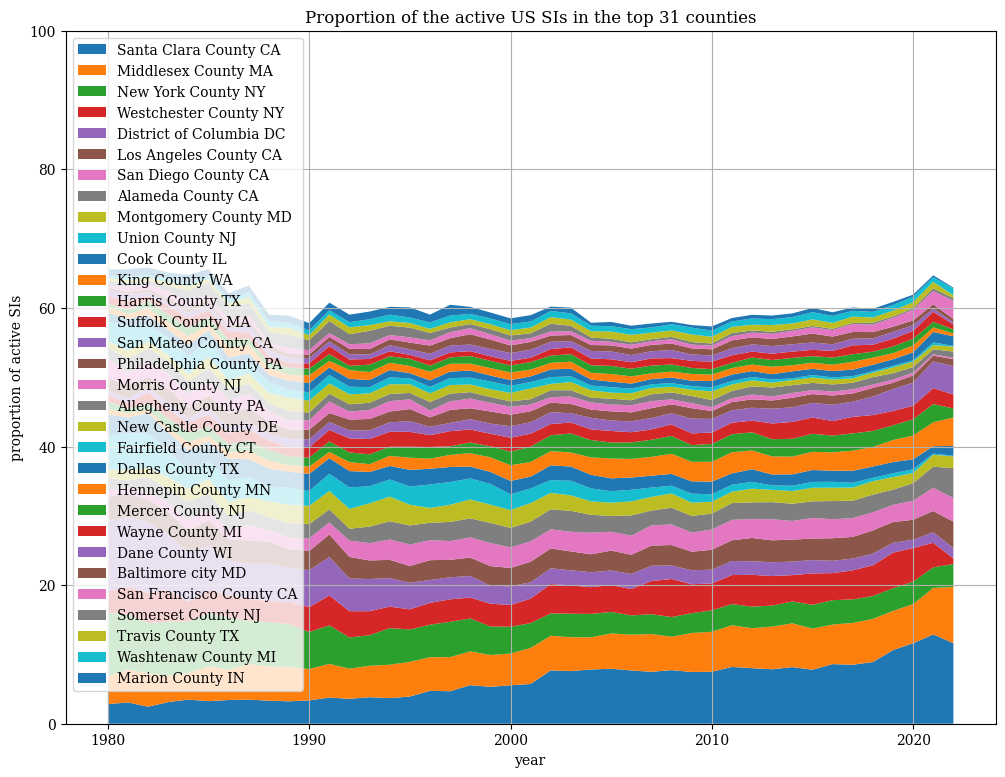

In [94]:
## plot the proportion of SIs in the top 1% counties

list_10_counties = list(dic_year_counties_sorted.keys())[:31]


plt.figure(figsize = (12,9))
legend = []
pre_county = np.zeros((2023-1980))


num_plots = 31


k = 0 

for county in tqdm(list_10_counties):
    k = np.random.randint(0,num_plots)
    plt.fill_between(dic_year_counties_sorted[county].keys() , np.array(list(dic_year_counties_sorted[county].values())) + pre_county   , pre_county  )
    pre_county = np.array(list(dic_year_counties_sorted[county].values())) + pre_county
    legend.append(geo_file[geo_file["fips"] == int(county)]["country_state"].tolist()[0])
    k += 1
    
    
plt.legend(legend , loc="upper left")
plt.grid()
plt.xlabel("year")
plt.ylim([0,100])
plt.ylabel("proportion of active SIs")
plt.title("Proportion of the active US SIs in the top 31 counties")

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.33it/s]


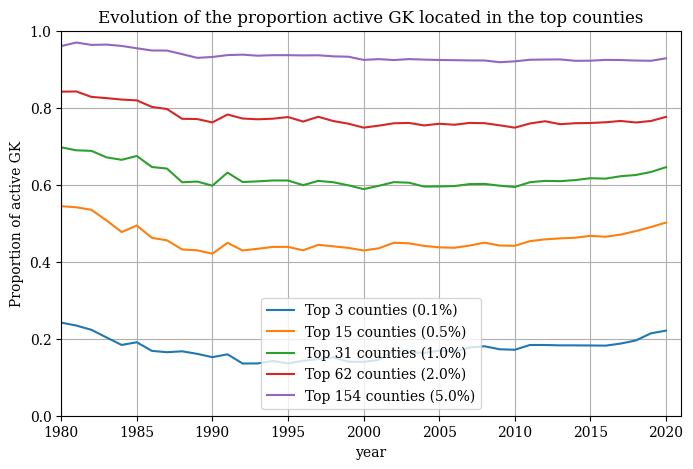

In [96]:
## plot proportion of SIs for different % of counties 

plt.figure(figsize = (8,5))
legend = [] 
for value in tqdm([3,15,31,62,154]):

    X = [ year for year in range(1980,2021)]
    Y = []
    for year in range(1980,2021):
        df_gk = pd.DataFrame(dic_gk[year]).T.sort_values("values" , ascending = False)

        sum_gk = sum(df_gk["values"])

        prop = sum(df_gk.head(value)["values"])/sum_gk
        Y.append(prop)
    legend.append(f'Top {value} counties ({round(100*value/3055,1)}%)')
    plt.plot(X,Y)
    
plt.legend(legend)
plt.ylim([0,1])
plt.xlim([1980,2021])
plt.xlabel("year")
plt.ylabel("Proportion of active GK") 
plt.title("Evolution of the proportion active GK located in the top counties")
plt.grid()
plt.show()

### Plots: Gini coefficient 

In [97]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [98]:
## calculate the gini coefficient for each year

dic_gini = { year : 0 for year in range(1980,2023) }
counties_per_year  = { year : np.zeros((3055)) for year in range(1980,2023) }


for year in tqdm(range(1980,2023)):
    for k in range(len(dic_year_counties_sorted)):
        
        county = list(dic_year_counties_sorted.keys())[k]
        counties_per_year[year][k] = dic_year_counties_sorted[county][year]
            
    dic_gini[year] = gini(counties_per_year[year])
            
    

100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 19.16it/s]


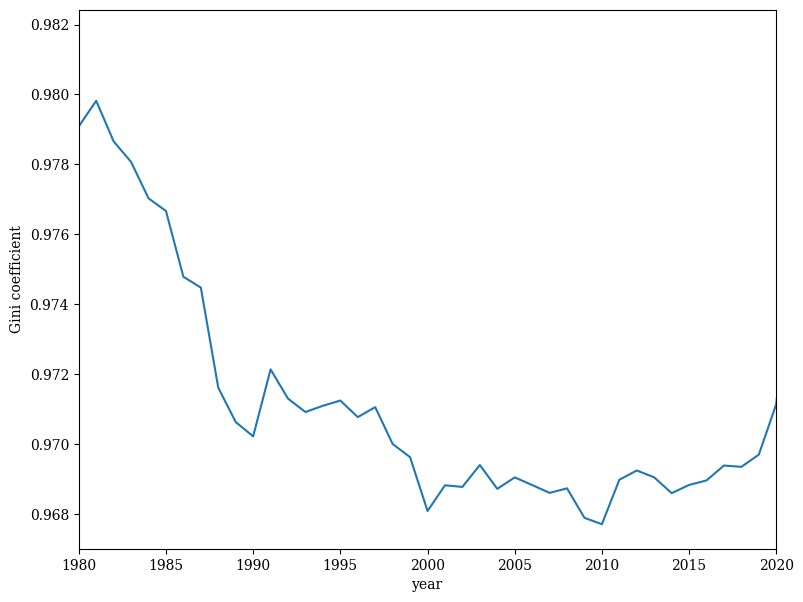

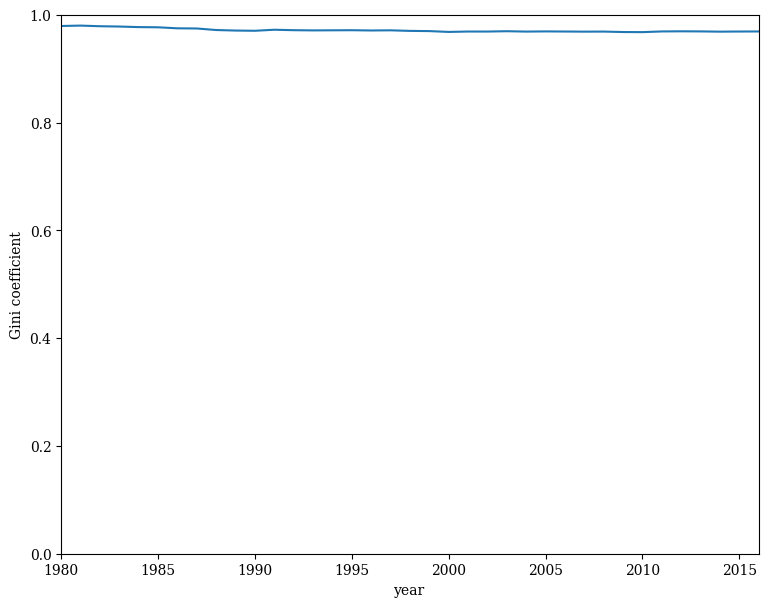

In [100]:
## plot gini coefficient 

plt.figure(figsize = (9,7))
plt.plot(dic_gini.keys() , dic_gini.values())
plt.xlabel("year")
plt.ylabel("Gini coefficient")
#plt.title("Gini coefficient by counties - active GateKeepers")
plt.xlim([1980,2020])
plt.show()

plt.figure(figsize = (9,7))
plt.plot(dic_gini.keys() , dic_gini.values())
plt.ylim([0,1])
plt.xlabel("year")
plt.ylabel("Gini coefficient")
#plt.title("Gini coefficient by counties - active GateKeepers")
plt.xlim([1980,2016])
plt.show()


### Plot: skyscrapper maps

In [47]:
## generate file for skyscrapper map

year = 2016

gk_table  = pd.DataFrame(dic_gk[year]).T

df = geo_file[["fips" , "NAMELSAD" , "STUSAB" , "Geo Point", 'polygon_map' ]].merge(gk_table, left_on='fips', right_on = "Fips", how='outer')
df = df[df["polygon_map"].notnull()]
df = df[df["values"].notnull()]

df["longitude"]  = [ float(elem.split(", ")[1]) for elem in df["Geo Point"] ] 
df["latitude"]  = [ float(elem.split(", ")[0]) for elem in df["Geo Point"] ] 




dic_df = df.to_dict("index")

dic_map = {}
count = 0 

for elem in dic_df:
    values = dic_df[elem]["values"]
    longitude = dic_df[elem]["longitude"]
    latitude = dic_df[elem]["latitude"]
    for k in range(int(values)):
        dic_map[count] = {}
        dic_map[count]["longitude"] = longitude
        dic_map[count]["latitude"] = latitude
        count += 1

        
df_map = pd.DataFrame(dic_map).T

In [48]:
## plot skyscrapper map 

max_value = 20*max(df["values"])
#max_value = 50*max(df["values"])


layer = pdk.Layer(
    'HexagonLayer',  # `type` positional argument is here
    df_map,
    get_position=['longitude', 'latitude'],
    auto_highlight=True,
    elevation_scale=20,
    pickable=True,
    elevation_range=[0, max_value],
    extruded=True,
    coverage=10)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=-85,
    latitude=40,
    zoom=6,
    min_zoom=1,
    max_zoom=9,
    bearing=10,
    pitch=40)

# Combined all of it and render a viewport
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html(main_path + 'figures/skyscraper_map_cs_2016.html')
#r.to_html(main_path + 'figures/skyscraper_map_all_2016.html')


In [44]:
## generate file for skyscrapper map

year = 1990

gk_table  = pd.DataFrame(dic_gk[year]).T

df = geo_file[["fips" , "NAMELSAD" , "STUSAB" , "Geo Point", 'polygon_map' ]].merge(gk_table, left_on='fips', right_on = "Fips", how='outer')
df = df[df["polygon_map"].notnull()]
df = df[df["values"].notnull()]

df["longitude"]  = [ float(elem.split(", ")[1]) for elem in df["Geo Point"] ] 
df["latitude"]  = [ float(elem.split(", ")[0]) for elem in df["Geo Point"] ] 


dic_df = df.to_dict("index")

dic_map = {}
count = 0 

for elem in dic_df:
    values = dic_df[elem]["values"]
    longitude = dic_df[elem]["longitude"]
    latitude = dic_df[elem]["latitude"]
    for k in range(int(values)):
        dic_map[count] = {}
        dic_map[count]["longitude"] = longitude
        dic_map[count]["latitude"] = latitude
        count += 1

        
df_map = pd.DataFrame(dic_map).T

In [45]:
## plot skyscrapper map

#max_value = 20*max(df["values"])
max_value = 50*max(df["values"])

layer = pdk.Layer(
    'HexagonLayer',  # `type` positional argument is here
    df_map,
    get_position=['longitude', 'latitude'],
    auto_highlight=True,
    elevation_scale=20,
    pickable=True,
    elevation_range=[0, max_value],
    extruded=True,
    coverage=10,
    #get_color=[0, 0, 0],
    )

# Set the viewport location
view_state = pdk.ViewState(
    longitude=-85,
    latitude=40,
    zoom=6,
    min_zoom=1,
    max_zoom=9,
    pitch=30,
    bearing=10)

# Combined all of it and render a viewport
r = pdk.Deck(layers=[layer] ,initial_view_state=view_state,)
#r.to_html('figures/skyscraper_map_all_1990.html')
r.to_html('figures/skyscraper_map_cs_1990.html')

/tmp/ipykernel_120366/3987073123.py:2: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap = 'YlOrRd', norm = plc.Normalize(0,  max(df["values"]))))


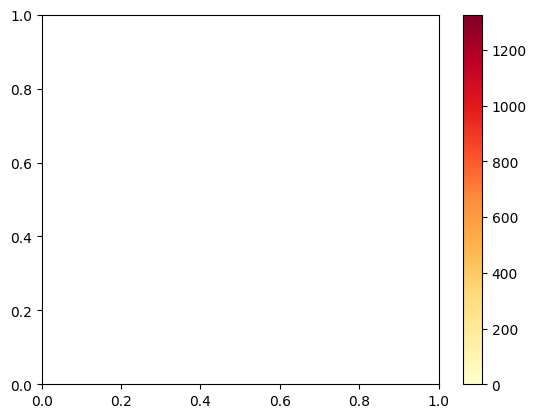

In [49]:
## print color bar
plt.colorbar(plt.cm.ScalarMappable(cmap = 'YlOrRd', norm = plc.Normalize(0,  max(df["values"]))))


### Plot: GDP

In [12]:
## load gdp by county 

with open(main_path + 'data/county_gdp_2001_2020.csv') as f:
    
    df_gdp = pd.read_csv(f)
    df_gdp = df_gdp.rename( columns = { "GeoFIPS" : "GEOID" } )
    df_gdp["GEOID"] =  [ str(elem).zfill(5) for elem in df_gdp["GEOID"] ] 
    df_gdp = df_gdp.astype(  { "GEOID" : "int64" } )


In [13]:
## merge gdp file and county file 

df_counties_gk_gdp = geo_file.merge(df_gdp, on='GEOID', how='inner')
df_counties_gk_gdp = df_counties_gk_gdp.rename( columns = { "GEOID" : "Fips" ,  "Geo Shape" : "Geo_Shape" } )
df_counties_gk_gdp = df_counties_gk_gdp.astype(  { "Fips" : "int64" } )

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


[0.3193057824327593, 0.31534848903166096, 0.3122748919269429, 0.3116050398671952, 0.3114876013148249, 0.3131392854747209, 0.31380445023582726, 0.31041401831395277, 0.3100028596082305, 0.3106004364415296, 0.3113927513665107, 0.314826641537216, 0.3155897989760322, 0.31750105397969863, 0.3233211909167989, 0.3277607994065604, 0.3298070018924274, 0.33238257633009055, 0.3350843270307929, 0.33553148030089336]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.89it/s]


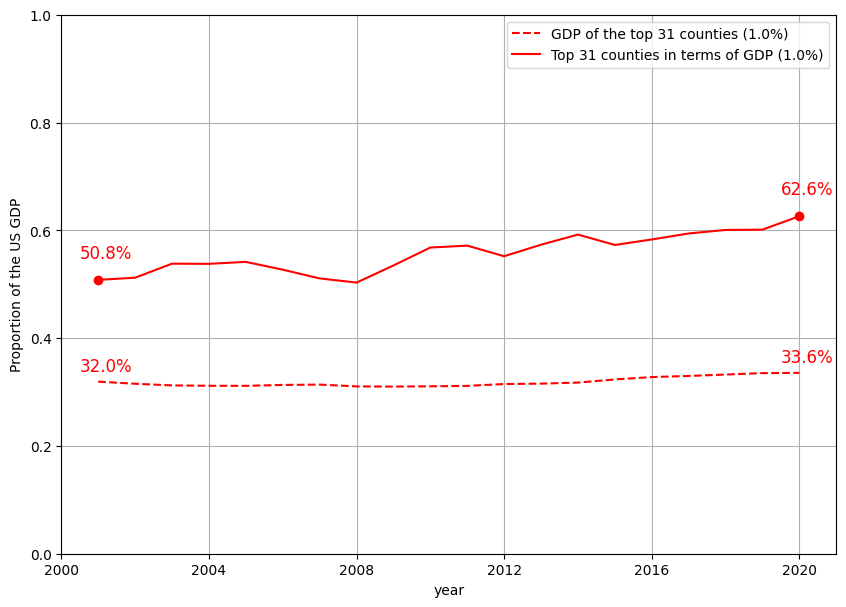

In [35]:
## plot gdp vs proportion of SIs

plt.figure(figsize = (10,7))
legend = [] 
colors = ['red','blue']
k = 0 
for value in tqdm([31]):


    X = [ year for year in range(2001,2021)]
    Y = []
    for year in range(2001,2021):
        df_gk = pd.DataFrame(dic_gk[year]).T.sort_values("values" , ascending = False)
        df_gk = df_gk[df_gk["Fips"].notnull()]
        df_gk = df_gk.astype( { "Fips" : "int64" })
        res = df_gk.merge(df_counties_gk_gdp[['Fips', 'Geo Point', 'Geo_Shape', 'STATEFP', str(year)]], on='Fips', how='outer')
        res = res[res["Geo_Shape"].notnull()]
        res = res[pd.isna(res[str(year)]) == False]
        res["values"] = res['values'].fillna(0)
        res = res.sort_values(str(year) , ascending = False)


        sum_gdp = sum(res[str(year)])

        prop = sum(res[:value][str(year)])/sum_gdp
        Y.append(prop)
    plt.plot(X,Y, linestyle='--', color = colors[k], label=f'GDP of the top {value} counties ({round(100*value/3055,1)}%)')
    plt.text(2000.5, Y[0]+0.02, str(100*round(Y[0],2) ) + "%" , fontsize = 12, color = colors[k])
    plt.text(2019.5, Y[-1]+0.02, str(100*round(Y[-1],3) ) + "%" , fontsize = 12, color = colors[k])
    print(Y)
    k += 1

k = 0 
for value in tqdm([31]):

    X = [ year for year in range(2001,2021)]
    Y = []
    for year in range(2001,2021):
        df_counties_gk_gdp = df_counties_gk_gdp.sort_values(str(year) , ascending = False)
        fips = set(df_counties_gk_gdp[:value]["Fips"].tolist())
        df_gk = pd.DataFrame(dic_gk[year]).T.sort_values("values" , ascending = False)
        df_gk = df_gk[df_gk["Fips"].notnull()]
        df_gk = df_gk.astype( { "Fips" : "int64" })
        
        sum_gk = sum(df_gk["values"])

        prop = sum(df_gk[df_gk["Fips"].isin(fips)]["values"])/sum_gk
        Y.append(prop)

        
        #print(set(df_gk[:value]["Fips"].to_list()) & set(df_counties_gk_gdp[:value]["Fips"].to_list()) )
    
    plt.plot(X,Y, color = colors[k], label=f'Top {value} counties in terms of GDP ({round(100*value/3055,1)}%)')
    plt.plot([2001,2020],[Y[0],Y[-1]], 'o',color = colors[k], )
    plt.text(2000.5, Y[0]+0.04, str(100*round(Y[0],3) ) + "%" , fontsize = 12, color = colors[k])
    plt.text(2019.5, Y[-1]+0.04, str(100*round(Y[-1],3) ) + "%" , fontsize = 12, color = colors[k])

    k += 1



plt.legend()
plt.ylim([0,1])
plt.xlim([2000,2021])
plt.xlabel("year")
plt.ylabel("Proportion of the US GDP") 
plt.xticks([k for k in range(2000,2021,4)])
#plt.title("Evolution of the proportion of the US GDP corresponding to the counties the highest GDP")
plt.grid()
plt.show()

## SIs affiliations

### Get SIs main affiliations

In [ ]:
## load OA institutions
table_institutions = pd.read_csv(main_path + "data/institutions_up_to_20230817_fips.tsv" , delimiter = "\t" , index_col = 0)
dic_ww_institutions = table_institutions.to_dict("index")

## identify US institutions
US_institutions = set(table_institutions[table_institutions['country_code'] == 'US'].index)


## function to get the most commen element of a list
def most_common(lst):
    if lst==[]:
        return None
    return max(set(lst), key=lst.count)



## store the SIs main affiliations in dic_types_institutions
dic_types_institutions = {}
kk = 0 

for count in tqdm(list(dic_clusters.keys())):

    if len(dic_clusters[count]["active_years_mag"] ) > 0:

        active_years = dic_clusters[count]["active_years_mag"]

        ## consider each active year
        for active_year in active_years:


            list_types_OA= []
            list_types_PV= []
            list_institutions = []
            list_assignees = []
    
            list_types_OA_US = []
            list_institutions_US = []
            
            ## identify the papers published during the given active year
            for author_id in dic_clusters[count]["OA"]:
                author_id = author_id[0]
        
                for work_id in dic_works[author_id]:
    
                    if int(work_id[1:]) in dic_gk_mag_years and int(str(dic_gk_mag_years[int(work_id[1:])]["year"])[:4]) == active_year:
                        
                        institutions = dic_works[author_id][work_id]["institution_id"]

                        ## store institutions and institutions types (for US and worldwide institutions)
                        if institutions != None:
                            for institution_id in institutions:


                                ## worldwide institutions
                                list_institutions.append(institution_id)

                                
                                if institution_id in dic_ww_institutions and dic_ww_institutions[institution_id]["type"] != None and pd.isna(dic_ww_institutions[institution_id]["type"]) == False:
                                        
                                    if dic_ww_institutions[institution_id]["type"] == "education":
                                        list_types_OA.append("UNIVERSITY")
                                    elif dic_ww_institutions[institution_id]["type"] == "facility":
                                        list_types_OA.append("GOV NON-PROFIT")
                                    elif dic_ww_institutions[institution_id]["type"] == "government":
                                        list_types_OA.append("GOV NON-PROFIT")
                                    elif dic_ww_institutions[institution_id]["type"] == "nonprofit":
                                        list_types_OA.append("GOV NON-PROFIT")
                                    elif dic_ww_institutions[institution_id]["type"] == "healthcare":
                                        list_types_OA.append("HOSPITAL")
                                    else:
                                        list_types_OA.append(dic_ww_institutions[institution_id]["type"].upper())

                                ## US institutions only
                                if institution_id in US_institutions:
                                    list_institutions_US.append(institution_id)
                                    
                                    if institution_id in dic_ww_institutions and dic_ww_institutions[institution_id]["type"] != None and pd.isna(dic_ww_institutions[institution_id]["type"]) == False:
                                            
                                        if dic_ww_institutions[institution_id]["type"] == "education":
                                            list_types_OA_US.append("UNIVERSITY")
                                        elif dic_ww_institutions[institution_id]["type"] == "facility":
                                            list_types_OA_US.append("GOV NON-PROFIT")
                                        elif dic_ww_institutions[institution_id]["type"] == "government":
                                            list_types_OA_US.append("GOV NON-PROFIT")
                                        elif dic_ww_institutions[institution_id]["type"] == "nonprofit":
                                            list_types_OA_US.append("GOV NON-PROFIT")
                                        elif dic_ww_institutions[institution_id]["type"] == "healthcare":
                                            list_types_OA_US.append("HOSPITAL")
                                        else:
                                            list_types_OA_US.append(dic_ww_institutions[institution_id]["type"].upper())
                                    
                                    
                         
            ## identify the patents published during the given active year                           
            for inventor_id in dic_clusters[count]["PV"]:
                inventor_id = inventor_id[0]
        
                if inventor_id in dic_patents:
                    for patent_id in dic_patents[inventor_id]:

                        ## store assignees and assignees types
                        if dic_patents[inventor_id][patent_id]["application_date"] != None and int(dic_patents[inventor_id][patent_id]["application_date"][-4:]) == active_year:
                            
                            list_types_PV += dic_patents[inventor_id][patent_id]["assignee_type"]
                                
                            for assignee in dic_patents[inventor_id][patent_id]["assignees"]:
    
                                list_assignees.append(dic_patents[inventor_id][patent_id]["assignees"][assignee]["assignee_name"])
                                    
            ## store the most common institutions / assignees / institution types / assignee types     
            dic_types_institutions[kk] = {}
            dic_types_institutions[kk]["active_year"] = active_year
            dic_types_institutions[kk]["institution_OA"] = most_common(list_types_OA)
            dic_types_institutions[kk]["institution_PV"] = most_common(list_types_PV)
            dic_types_institutions[kk]["assignees"] = most_common(list_assignees)
            dic_types_institutions[kk]["institutions"] = most_common(list_institutions)

            dic_types_institutions[kk]["institution_OA_US"] = most_common(list_types_OA_US)
            dic_types_institutions[kk]["institutions_US"] = most_common(list_institutions_US)

            ## store field of study 
            if count in dic_concepts_cpcs:
                dic_types_institutions[kk]["concept"] = dic_concepts_cpcs[count]["concept"]
                dic_types_institutions[kk]["cpc"] = dic_concepts_cpcs[count]["cpc"]
            else:
                dic_types_institutions[kk]["concept"] = None
                dic_types_institutions[kk]["cpc"] = None
                        

            if dic_types_institutions[kk]["institution_OA"] not in [ "COMPANY" , "UNIVERSITY" , "GOV NON-PROFIT",  "HOSPITAL"]:
                dic_types_institutions[kk]["institution_OA"] = "OTHER"
            if dic_types_institutions[kk]["institution_PV"] not in [ "COMPANY" , "UNIVERSITY" , "GOV NON-PROFIT",  "HOSPITAL"]:
                dic_types_institutions[kk]["institution_PV"] = "OTHER"
 
 
            
            kk += 1
            
        
                                                                       
            


In [ ]:
## save  SI affiliations

import json
json = json.dumps(dic_types_institutions)
f = open(main_path + "data/dic_types_institutions_mag_05.json","w")
f.write(json)
f.close()

### Plots 

In [16]:
## load SI affiliations

f = open(main_path + "data/dic_types_institutions_mag_05.json","r")
import json
dic_types_institutions = json.load(f)

In [17]:
table_institutions = pd.read_csv(main_path + "data/institutions_up_to_20230817_fips.tsv" , delimiter = "\t" , index_col = 0)

table = pd.DataFrame(dic_types_institutions).T
table = table.merge(table_institutions[['display_name']] , left_on = 'institutions' , right_index = True , how = "left")


100%|█████████████████████████████| 1013161/1013161 [00:02<00:00, 447633.17it/s]


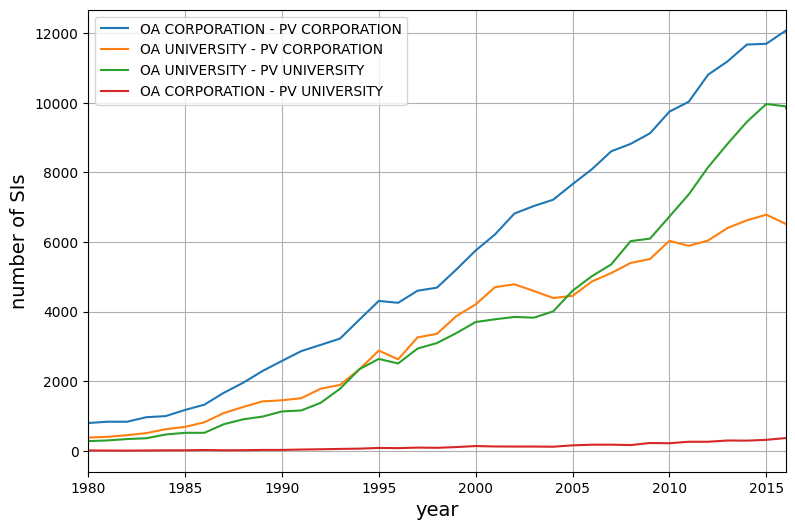

In [18]:
## store the main OA and PV affiliation types by year 

institution_per_year = {} 
list_inst = [ "COMPANY" , "UNIVERSITY" , "GOV NON-PROFIT" , "HOSPITAL"]

list_inst2= [ "COMPANY - UNIVERSITY" , "UNIVERSITY - UNIVERSITY" , "COMPANY - COMPANY" , "UNIVERSITY - COMPANY"]# , "UNIVERSITY - UNIVERSITY", "GOV NON-PROFIT - UNIVERSITY" ,"HOSPITAL - UNIVERSITY" ,"GOV NON-PROFIT - COMPANY" ] 

for count in tqdm(dic_types_institutions):
    main_institution_type = dic_types_institutions[count]["institution_OA"]
    sec_institution_type = dic_types_institutions[count]["institution_PV"]
    arrival_year = dic_types_institutions[count]["active_year"]
    if arrival_year in range(1980,2023) :
        if str(main_institution_type)  + " - " +  str(sec_institution_type) in list_inst2:
            if main_institution_type + " - " + sec_institution_type not in institution_per_year:
                institution_per_year[main_institution_type + " - " + sec_institution_type] = { year : 0 for year in range(1980,2023) } 
            institution_per_year[main_institution_type + " - " + sec_institution_type][arrival_year] += 1
            
        elif main_institution_type != None and sec_institution_type !=  None:
            if "OTHER" not in institution_per_year:
                institution_per_year["OTHER"] = { year : 0 for year in range(1980,2023) } 
            institution_per_year["OTHER"][arrival_year] += 1
        else:
            if "MISSING" not in institution_per_year:
                institution_per_year["MISSING"] = { year : 0 for year in range(1980,2023) } 
            institution_per_year["MISSING"][arrival_year] += 1


institution_per_year = { k : v for k , v in sorted(institution_per_year.items() , key= lambda item : item[1][2016] , reverse = True)}
elements = [ 'COMPANY - COMPANY',  'UNIVERSITY - COMPANY',  'UNIVERSITY - UNIVERSITY' , 'COMPANY - UNIVERSITY']#, 'OTHER','MISSING']
plt.figure( figsize = (9,6))
for elem in elements:
    plt.plot(list(institution_per_year[elem].keys()) , list(institution_per_year[elem].values()))
plt.legend([ 'OA CORPORATION - PV CORPORATION',  'OA UNIVERSITY - PV CORPORATION',  'OA UNIVERSITY - PV UNIVERSITY' , 'OA CORPORATION - PV UNIVERSITY'])
plt.xlim([1980,2016])
#plt.title("main affiliation types of the gatekeepers") 
plt.xlabel("year", fontsize = 14)
plt.ylabel("number of SIs", fontsize = 14)
plt.grid()
plt.show()

100%|█████████████████████████████| 1013161/1013161 [00:02<00:00, 439480.81it/s]


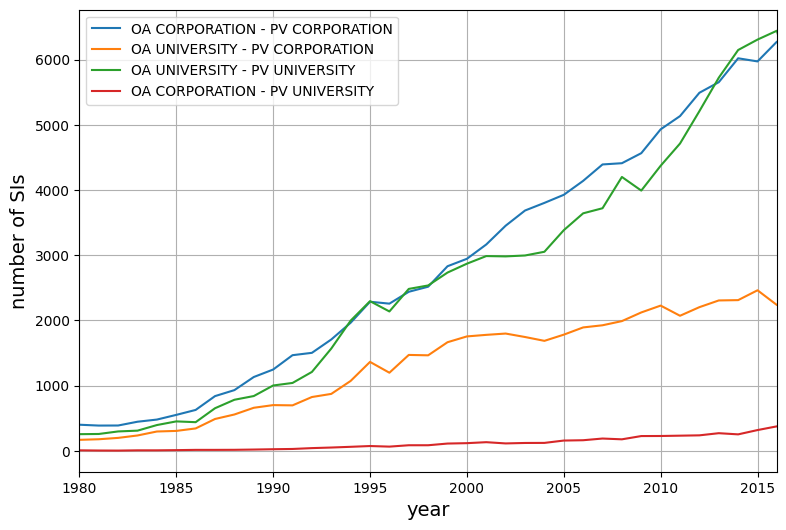

In [19]:
institution_per_year = {} 
list_inst = [ "COMPANY" , "UNIVERSITY" , "GOV NON-PROFIT" , "HOSPITAL"]

list_inst2= [ "COMPANY - UNIVERSITY" , "UNIVERSITY - UNIVERSITY" , "COMPANY - COMPANY" , "UNIVERSITY - COMPANY"]# , "UNIVERSITY - UNIVERSITY", "GOV NON-PROFIT - UNIVERSITY" ,"HOSPITAL - UNIVERSITY" ,"GOV NON-PROFIT - COMPANY" ] 

for count in tqdm(dic_types_institutions):

    main_institution_type = dic_types_institutions[count]["institution_OA_US"]
    sec_institution_type = dic_types_institutions[count]["institution_PV"]

    if dic_types_institutions[count]["institutions"] == 'I192545095':
        main_institution_type = "COMPANY"
    
    arrival_year = dic_types_institutions[count]["active_year"]
    if arrival_year in range(1980,2023) :
        if str(main_institution_type)  + " - " +  str(sec_institution_type) in list_inst2:
            if main_institution_type + " - " + sec_institution_type not in institution_per_year:
                institution_per_year[main_institution_type + " - " + sec_institution_type] = { year : 0 for year in range(1980,2023) } 
            institution_per_year[main_institution_type + " - " + sec_institution_type][arrival_year] += 1
            
        elif main_institution_type != None and sec_institution_type !=  None:
            if "OTHER" not in institution_per_year:
                institution_per_year["OTHER"] = { year : 0 for year in range(1980,2023) } 
            institution_per_year["OTHER"][arrival_year] += 1
        else:
            if "MISSING" not in institution_per_year:
                institution_per_year["MISSING"] = { year : 0 for year in range(1980,2023) } 
            institution_per_year["MISSING"][arrival_year] += 1
            
institution_per_year = { k : v for k , v in sorted(institution_per_year.items() , key= lambda item : item[1][2016] , reverse = True)}
elements = [ 'COMPANY - COMPANY',  'UNIVERSITY - COMPANY',  'UNIVERSITY - UNIVERSITY' , 'COMPANY - UNIVERSITY']#, 'OTHER','MISSING']
plt.figure( figsize = (9,6))
for elem in elements:
    plt.plot(list(institution_per_year[elem].keys()) , list(institution_per_year[elem].values()))
plt.legend([ 'OA CORPORATION - PV CORPORATION',  'OA UNIVERSITY - PV CORPORATION',  'OA UNIVERSITY - PV UNIVERSITY' , 'OA CORPORATION - PV UNIVERSITY'])
plt.xlim([1980,2016])
#plt.title("main affiliation types of the SI (US only)", fontsiz) 
plt.xlabel("year", fontsize = 14)
plt.ylabel("number of SIs", fontsize = 14) 
plt.grid()
plt.show()

100%|█████████████████████████████| 1013161/1013161 [00:01<00:00, 997026.46it/s]


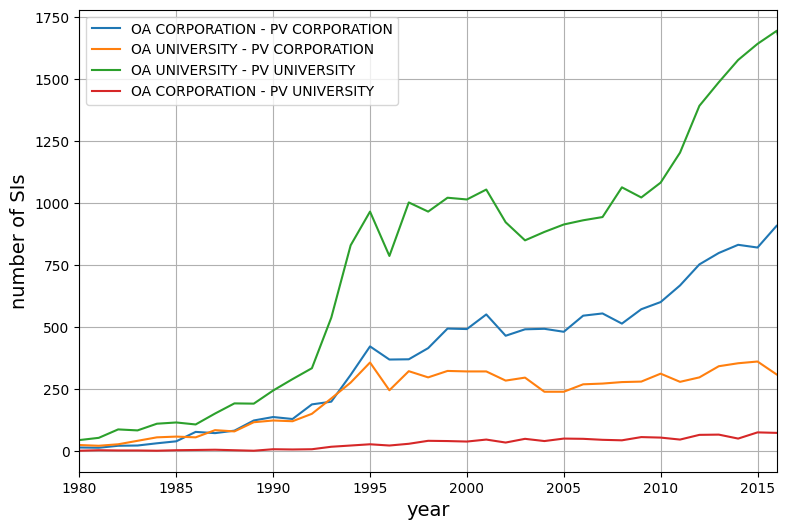

In [20]:
institution_per_year = {} 
list_inst = [ "COMPANY" , "UNIVERSITY" , "GOV NON-PROFIT" , "HOSPITAL"]

list_inst2= [ "COMPANY - UNIVERSITY" , "UNIVERSITY - UNIVERSITY" , "COMPANY - COMPANY" , "UNIVERSITY - COMPANY"]# , "UNIVERSITY - UNIVERSITY", "GOV NON-PROFIT - UNIVERSITY" ,"HOSPITAL - UNIVERSITY" ,"GOV NON-PROFIT - COMPANY" ] 

for count in tqdm(dic_types_institutions):

    if dic_types_institutions[count]["concept"] == "Biology":
        
        main_institution_type = dic_types_institutions[count]["institution_OA_US"]
        sec_institution_type = dic_types_institutions[count]["institution_PV"]
    
        if dic_types_institutions[count]["institutions"] == 'I192545095':
            main_institution_type = "COMPANY"
        
        arrival_year = dic_types_institutions[count]["active_year"]
        if arrival_year in range(1980,2023) :
            if str(main_institution_type)  + " - " +  str(sec_institution_type) in list_inst2:
                if main_institution_type + " - " + sec_institution_type not in institution_per_year:
                    institution_per_year[main_institution_type + " - " + sec_institution_type] = { year : 0 for year in range(1980,2023) } 
                institution_per_year[main_institution_type + " - " + sec_institution_type][arrival_year] += 1
                
            elif main_institution_type != None and sec_institution_type !=  None:
                if "OTHER" not in institution_per_year:
                    institution_per_year["OTHER"] = { year : 0 for year in range(1980,2023) } 
                institution_per_year["OTHER"][arrival_year] += 1
            else:
                if "MISSING" not in institution_per_year:
                    institution_per_year["MISSING"] = { year : 0 for year in range(1980,2023) } 
                institution_per_year["MISSING"][arrival_year] += 1
                

institution_per_year = { k : v for k , v in sorted(institution_per_year.items() , key= lambda item : item[1][2016] , reverse = True)}
elements = [ 'COMPANY - COMPANY',  'UNIVERSITY - COMPANY',  'UNIVERSITY - UNIVERSITY' , 'COMPANY - UNIVERSITY']#, 'OTHER','MISSING']
plt.figure( figsize = (9,6))
for elem in elements:
    plt.plot(list(institution_per_year[elem].keys()) , list(institution_per_year[elem].values()))
plt.legend([ 'OA CORPORATION - PV CORPORATION',  'OA UNIVERSITY - PV CORPORATION',  'OA UNIVERSITY - PV UNIVERSITY' , 'OA CORPORATION - PV UNIVERSITY'])
plt.xlim([1980,2016])
#plt.title("main affiliation types of the SI (US only) - BIOLOGY") 
plt.xlabel("year", fontsize = 14)
plt.ylabel("number of SIs", fontsize = 14)
plt.grid()
plt.show()

100%|█████████████████████████████| 1013161/1013161 [00:01<00:00, 792796.69it/s]


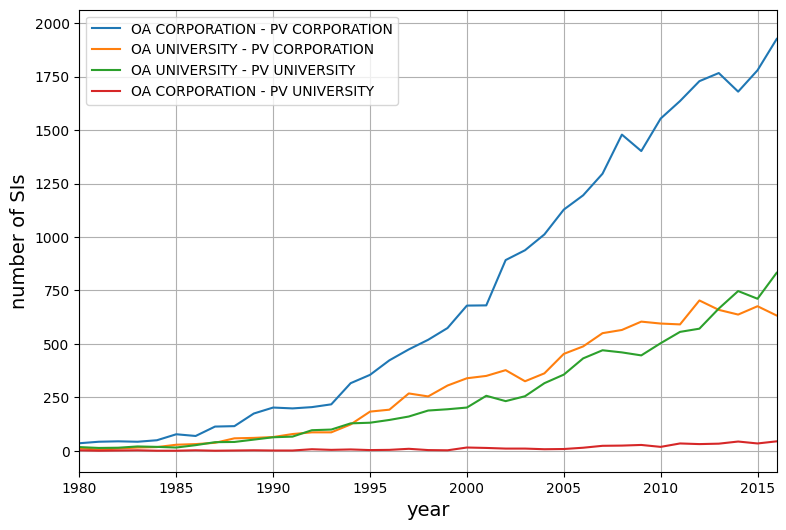

In [22]:
institution_per_year = {} 
list_inst = [ "COMPANY" , "UNIVERSITY" , "GOV NON-PROFIT" , "HOSPITAL"]

list_inst2= [ "COMPANY - UNIVERSITY" , "UNIVERSITY - UNIVERSITY" , "COMPANY - COMPANY" , "UNIVERSITY - COMPANY"]# , "UNIVERSITY - UNIVERSITY", "GOV NON-PROFIT - UNIVERSITY" ,"HOSPITAL - UNIVERSITY" ,"GOV NON-PROFIT - COMPANY" ] 

for count in tqdm(dic_types_institutions):

    if dic_types_institutions[count]["concept"] == "Computer science":
        
        main_institution_type = dic_types_institutions[count]["institution_OA_US"]
        sec_institution_type = dic_types_institutions[count]["institution_PV"]
    
        if dic_types_institutions[count]["institutions"] == 'I192545095':
            main_institution_type = "COMPANY"
        
        arrival_year = dic_types_institutions[count]["active_year"]
        if arrival_year in range(1980,2023) :
            if str(main_institution_type)  + " - " +  str(sec_institution_type) in list_inst2:
                if main_institution_type + " - " + sec_institution_type not in institution_per_year:
                    institution_per_year[main_institution_type + " - " + sec_institution_type] = { year : 0 for year in range(1980,2023) } 
                institution_per_year[main_institution_type + " - " + sec_institution_type][arrival_year] += 1
                
            elif main_institution_type != None and sec_institution_type !=  None:
                if "OTHER" not in institution_per_year:
                    institution_per_year["OTHER"] = { year : 0 for year in range(1980,2023) } 
                institution_per_year["OTHER"][arrival_year] += 1
            else:
                if "MISSING" not in institution_per_year:
                    institution_per_year["MISSING"] = { year : 0 for year in range(1980,2023) } 
                institution_per_year["MISSING"][arrival_year] += 1
                

institution_per_year = { k : v for k , v in sorted(institution_per_year.items() , key= lambda item : item[1][2016] , reverse = True)}
elements = [ 'COMPANY - COMPANY',  'UNIVERSITY - COMPANY',  'UNIVERSITY - UNIVERSITY' , 'COMPANY - UNIVERSITY']#, 'OTHER','MISSING']
plt.figure( figsize = (9,6))
for elem in elements:
    plt.plot(list(institution_per_year[elem].keys()) , list(institution_per_year[elem].values()))
plt.legend([ 'OA CORPORATION - PV CORPORATION',  'OA UNIVERSITY - PV CORPORATION',  'OA UNIVERSITY - PV UNIVERSITY' , 'OA CORPORATION - PV UNIVERSITY'])
plt.xlim([1980,2016])
#plt.title("main affiliation types of the SI (US only) - COMPUTER SCIENCE") 
plt.xlabel("year", fontsize = 14)
plt.ylabel("number of SIs", fontsize = 14) 
plt.grid()
plt.show()